# Incorporate Safety Specification to Learned Specification from User Demonstration on Seshia Paper's Env 

by Kandai Watanabe (kandai.watanabe@colorado.edu / kandai.wata@gmail.com)

or reach me out on github (https://github.com/watakandai)


**FOR SESHIA's paper on Learning Task Specifications from Demonstrations:**

In this notebook, we're going to incorporate safety specification to a learned specification (liveness) to safety navigate to a goal. 

We will then apply the composed specification to an environment with a different robot / environmental dynamics, but with the same intended goal as in the environment where we demonstrated the task.

This shows that we can actually learn the intended task the user had in mind when they demonstrate it on a system with actual dynamics, maitain safety, and then apply that specification to a different environment.



Change up to the main repo directory:

In [1]:
import os
os.chdir(os.path.join('..', '..'))

In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video, display
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from pathlib import Path
import itertools
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 18
plt.rcParams["font.weight"] = 'normal'
plt.rcParams["font.family"] = 'Times New Roman'

from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
from wombats.learning import FlexfringeInterface, TracesGenerator, GridSearch, Evaluator
from wombats.learning import Vanilla, Postprocess, GreedyPreprocess, Preprocess, TargetSpecification
from wombats.learning.metrics import DefaultEvaluationFunctions
from wombats.learning import Dataset
from wombats.automaton import Automaton
from wombats.utils import get_experiment_paths

## Environments
# Exp2
ENV_ID_1 = 'MiniGrid-LavaComparison_seshia-v0'
ENV_ID_2 = 'MiniGrid-LavaComparison_SeshiaOnlyWaterPath-v0'
ENV_ID_3 = 'MiniGrid-AlternateLavaComparison_AllCorridorsOpen_Wide-v0'
ENV_ID_4 = 'MiniGrid-AlternateLavaComparison_OnlyWaterPath_Wide-v0'
ENV_ID_5 = 'MiniGrid-AlternateLavaComparison_AllCorridorsOpen_Narrow-v0'
ENV_ID_6 = 'MiniGrid-AlternateLavaComparison_OnlyWaterPath_Narrow-v0'

# setting all paths
EXPERIMENT_NAME = 'safe_pdfa_learning_performance_analysis'
path_data = get_experiment_paths(EXPERIMENT_NAME)
EXPERIMENT_DIR = path_data['EXPERIMENT_DIR']
PDFA_MODEL_CONFIG_FILE = path_data['PDFA_MODEL_CONFIG_FILE']
DFA_MODEL_CONFIG_FILE = path_data['DFA_MODEL_CONFIG_FILE']
LEARNER_DATA_DIR = path_data['LEARNER_DATA_DIR']
LEARNING_TRAIN_DATA_REL_FILEPATH = path_data['LEARNING_TRAIN_DATA_REL_FILEPATH']
LEARNING_TEST_DATA_REL_FILEPATH = path_data['LEARNING_TEST_DATA_REL_FILEPATH']
GYM_MONITOR_LOG_DIR = path_data['GYM_MONITOR_LOG_DIR']
ANALYSIS_DATA_DIR = path_data['ANALYSIS_DATA_DIR']
Automaton.automata_data_dir = os.path.join(EXPERIMENT_DIR)

# Constants
test_size = 0.05
num_samples = np.logspace(1, 4, num=100)
# num_samples = np.logspace(1, 2, num=3)
Ns =  [20]

In [3]:
print(path_data)
print(Automaton.automata_data_dir)

{'EXPERIMENT_DIR': 'experiments/safe_pdfa_learning_performance_analysis', 'PDFA_MODEL_CONFIG_FILE': 'wombats/config/PDFA_safe_pdfa_learning_performance_analysis.yaml', 'DFA_MODEL_CONFIG_FILE': 'wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml', 'TS_MODEL_CONFIG_FILE': 'wombats/config/TS_safe_pdfa_learning_performance_analysis.yaml', 'GYM_MONITOR_LOG_DIR': 'experiments/safe_pdfa_learning_performance_analysis/minigrid_env_logs', 'LEARNER_DATA_DIR': 'experiments/safe_pdfa_learning_performance_analysis/flexfringe_data', 'LEARNING_TRAIN_DATA_REL_FILEPATH': 'flexfringe_data/safe_pdfa_learning_performance_analysis_train', 'LEARNING_TEST_DATA_REL_FILEPATH': 'flexfringe_data/safe_pdfa_learning_performance_analysis_test', 'ANALYSIS_DATA_DIR': 'experiments/safe_pdfa_learning_performance_analysis/analysis'}
experiments/safe_pdfa_learning_performance_analysis


In [4]:
def load_automata_from_experiment(experiment_name, env_id, draw=False, just_cosafe=False):
    path_data = get_experiment_paths(experiment_name)
    pdfa_model_config_file = path_data['PDFA_MODEL_CONFIG_FILE']
    dfa_model_config_file = path_data['DFA_MODEL_CONFIG_FILE']
    
    # cosafe
    try:
        cosafe_specification = active_automata.get(automaton_type='PDFA',
                                                   graph_data=pdfa_model_config_file,
                                                   is_normalized=True)
    except Exception as e:
        cosafe_specification = None
        
    # safe
    try:
        safe_specification = active_automata.get(automaton_type='DFA',
                                                 graph_data=dfa_model_config_file)
    except Exception as e:
        safe_specification = None
    
    # pdfa
    try:
        pdfa_specification = active_automata.get(automaton_type='PDFA',
                                                 graph_data=(cosafe_specification,
                                                             safe_specification),
                                                 graph_data_format='existing_objects',
                                                 normalize_trans_probabilities=True)
    except Exception as e:
        pdfa_specification = None
    
    # env
    env = gym.make(env_id)

    env = StaticMinigridTSWrapper(env, actions_type='simple_static',
                                  monitor_log_location=GYM_MONITOR_LOG_DIR)
    env.reset()

    minigrid_TS = active_automata.get(automaton_type='TS', graph_data=env,
                                      graph_data_format='minigrid')
    
    if draw: 
        try:
            cosafe_specification.draw('_'.join([EXPERIMENT_NAME, env_id, 'PDFA']))
            safe_specification.draw('_'.join([EXPERIMENT_NAME, env_id, 'DFA']))
            pdfa_specification.draw('_'.join([EXPERIMENT_NAME, env_id, 'SPECIFICATION']))
            env.render_notebook()
        
        except Exception as e:
            print(e)
#         minigrid_TS.draw('_'.join([EXPERIMENT_NAME, env_id, 'TS']))
    
    if just_cosafe:
        return cosafe_specification, minigrid_TS
    return pdfa_specification, safe_specification, minigrid_TS

In [5]:
def solve_environment(specification, ENV_ID, actions_type='simple_static',
                      show_figures=False, record_video=True):
    
    print('using env:', ENV_ID)
    print('using actions:', actions_type)

    env = gym.make(ENV_ID)
    env = StaticMinigridTSWrapper(env, actions_type=actions_type,
                                  monitor_log_location=GYM_MONITOR_LOG_DIR)
    env.reset()
    
    TS = active_automata.get(automaton_type='TS', graph_data=env,
                             graph_data_format='minigrid')

    if show_figures:
        env.render_notebook()
        print('underlying transition system')
        TS.draw('_'.join([EXPERIMENT_NAME, ENV_ID_1, 'TS']))

    product = active_automata.get(automaton_type='Product',
                                  graph_data=(TS, specification))
    if show_figures:
        print('specification')
        specification.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'learned', 'pdfa']))
        print('product automaton')
        product.draw('_'.join([EXPERIMENT_NAME, ENV_ID, 'learned', 'product']))

    (controls,
     prob_of_controls_under_spec) = product.compute_strategy()

    print(f'Optimal Controls: {controls}')
    print(f'Probability of Generated TS Observations in Spec: ' +
          f'{prob_of_controls_under_spec}')

    (output_string,
     visited_states,
     video_path) = TS.run(controls, record_video=record_video)
    
    print(output_string)
    print(visited_states)
    if record_video:
        v = Video(video_path, embed=True,
                  html_attributes="controls muted autoplay loop")
        display(v)

In [6]:
def eval_sampled_traces(traces, record_video=False):
    if traces is None:
        return
    
    output_strings = []
    for controls, length, prob in zip(*traces):
        if controls is None:
            continue
        output_string, _, video_path = minigrid_TS.run(
            controls,
            record_video=record_video,
            overwrite_old_video=record_video)
        output_strings.append(output_string)
        
        if record_video:
            print(pdfa_specification.cross_entropy_approx(output_string))
            print(prob)
            print(length)
        
        if record_video:
            v = Video(video_path, embed=True,
                      html_attributes="controls muted autoplay loop")
            display(v)
        
    return output_strings

# Sample from the true PDFA

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:720: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


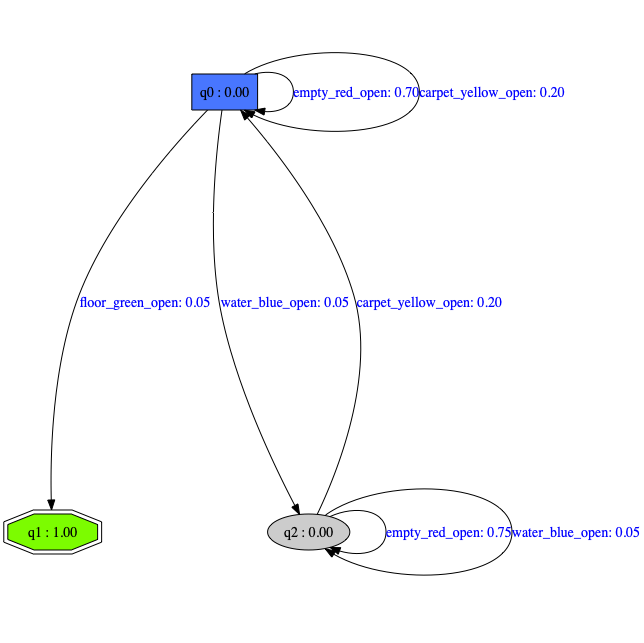

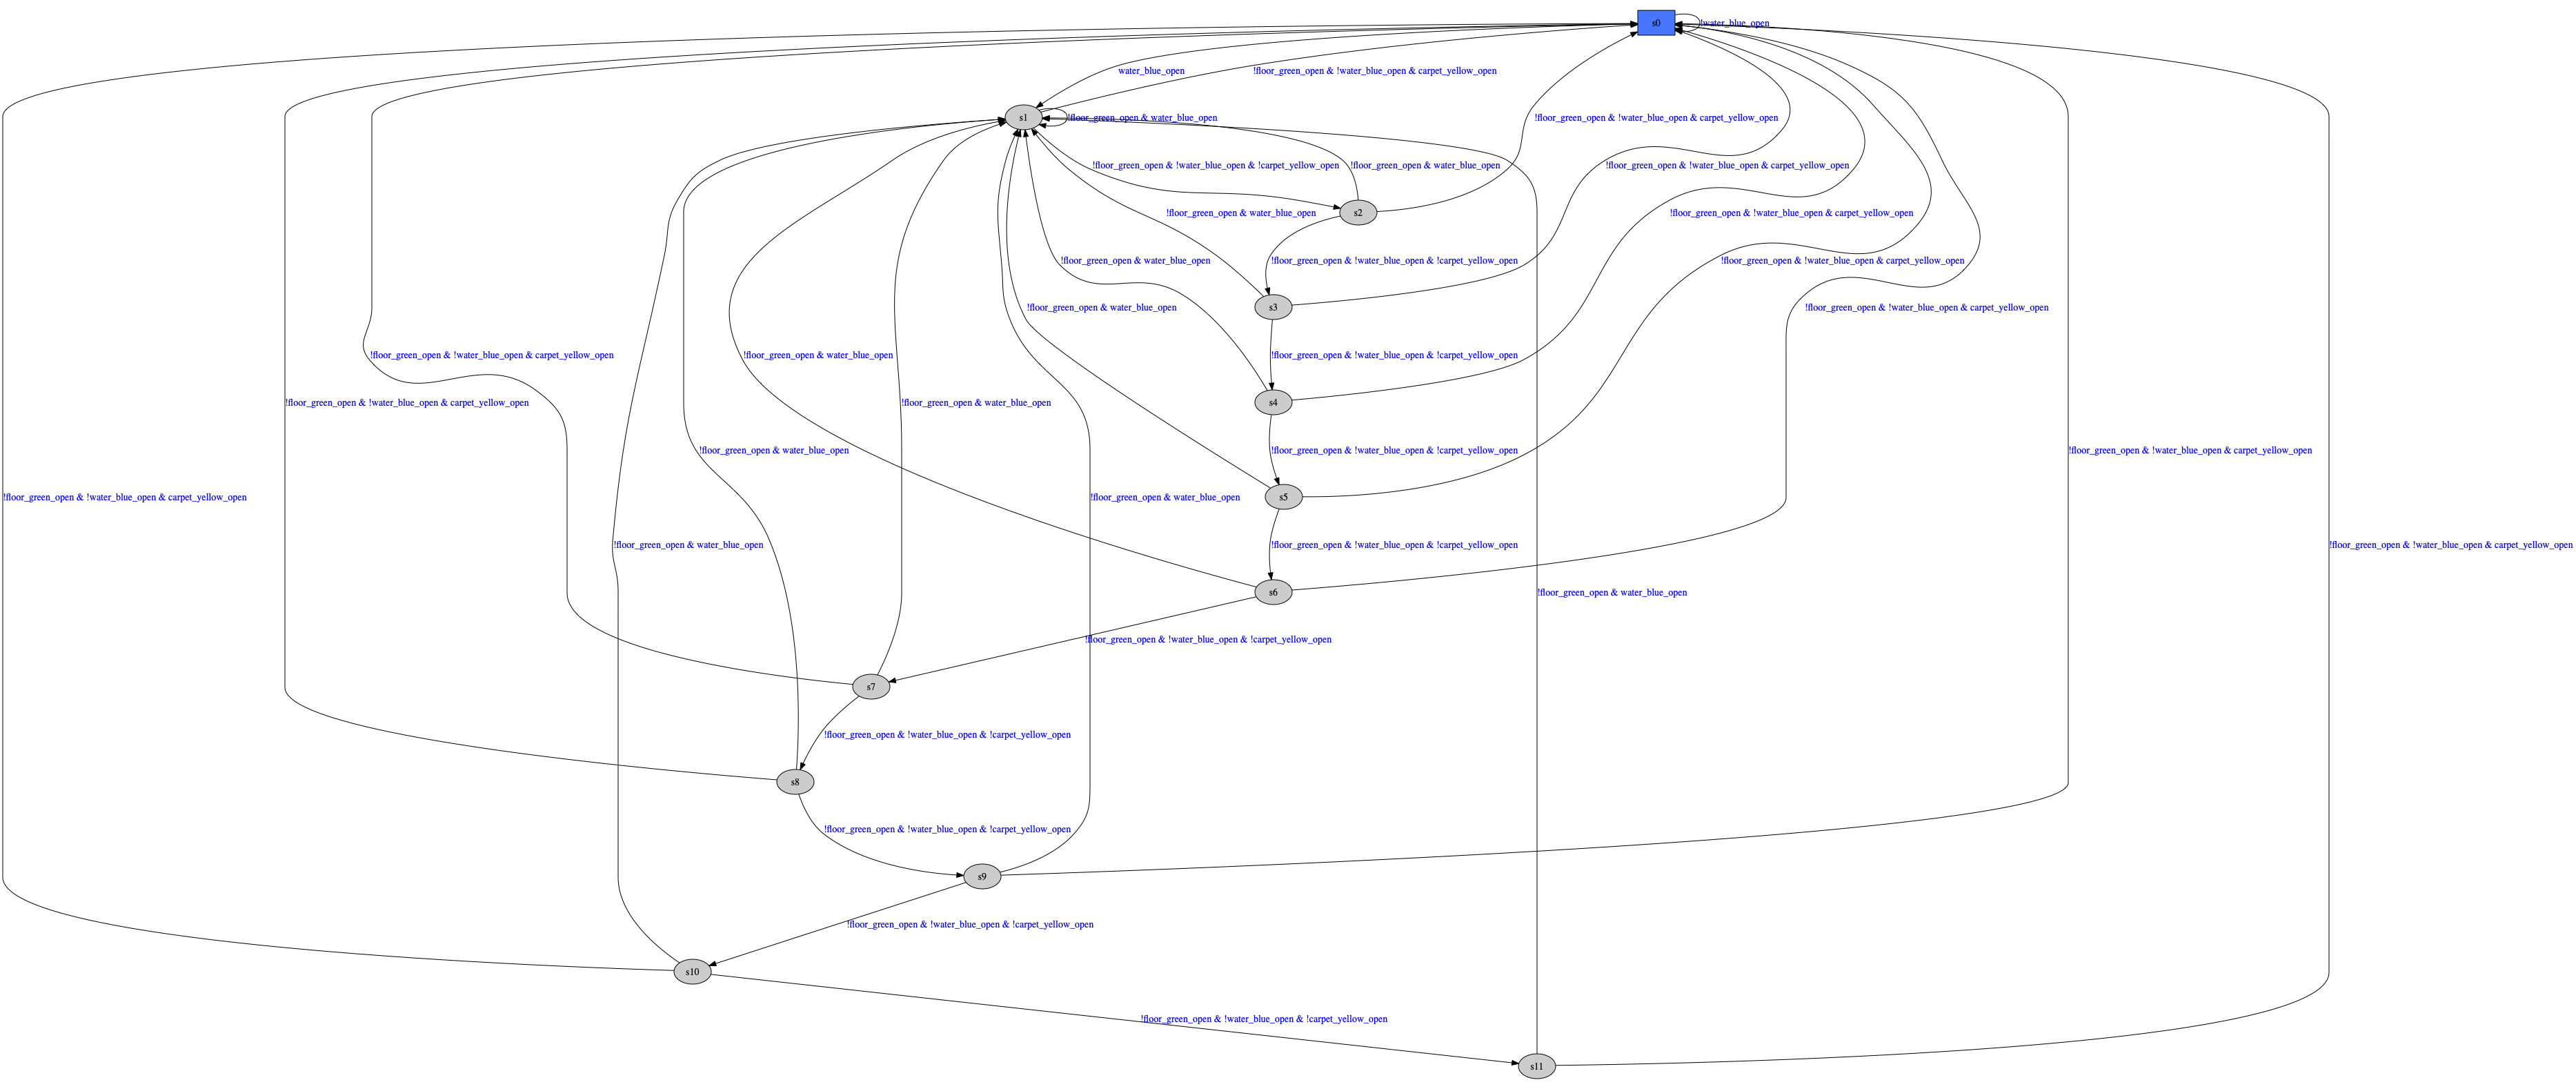

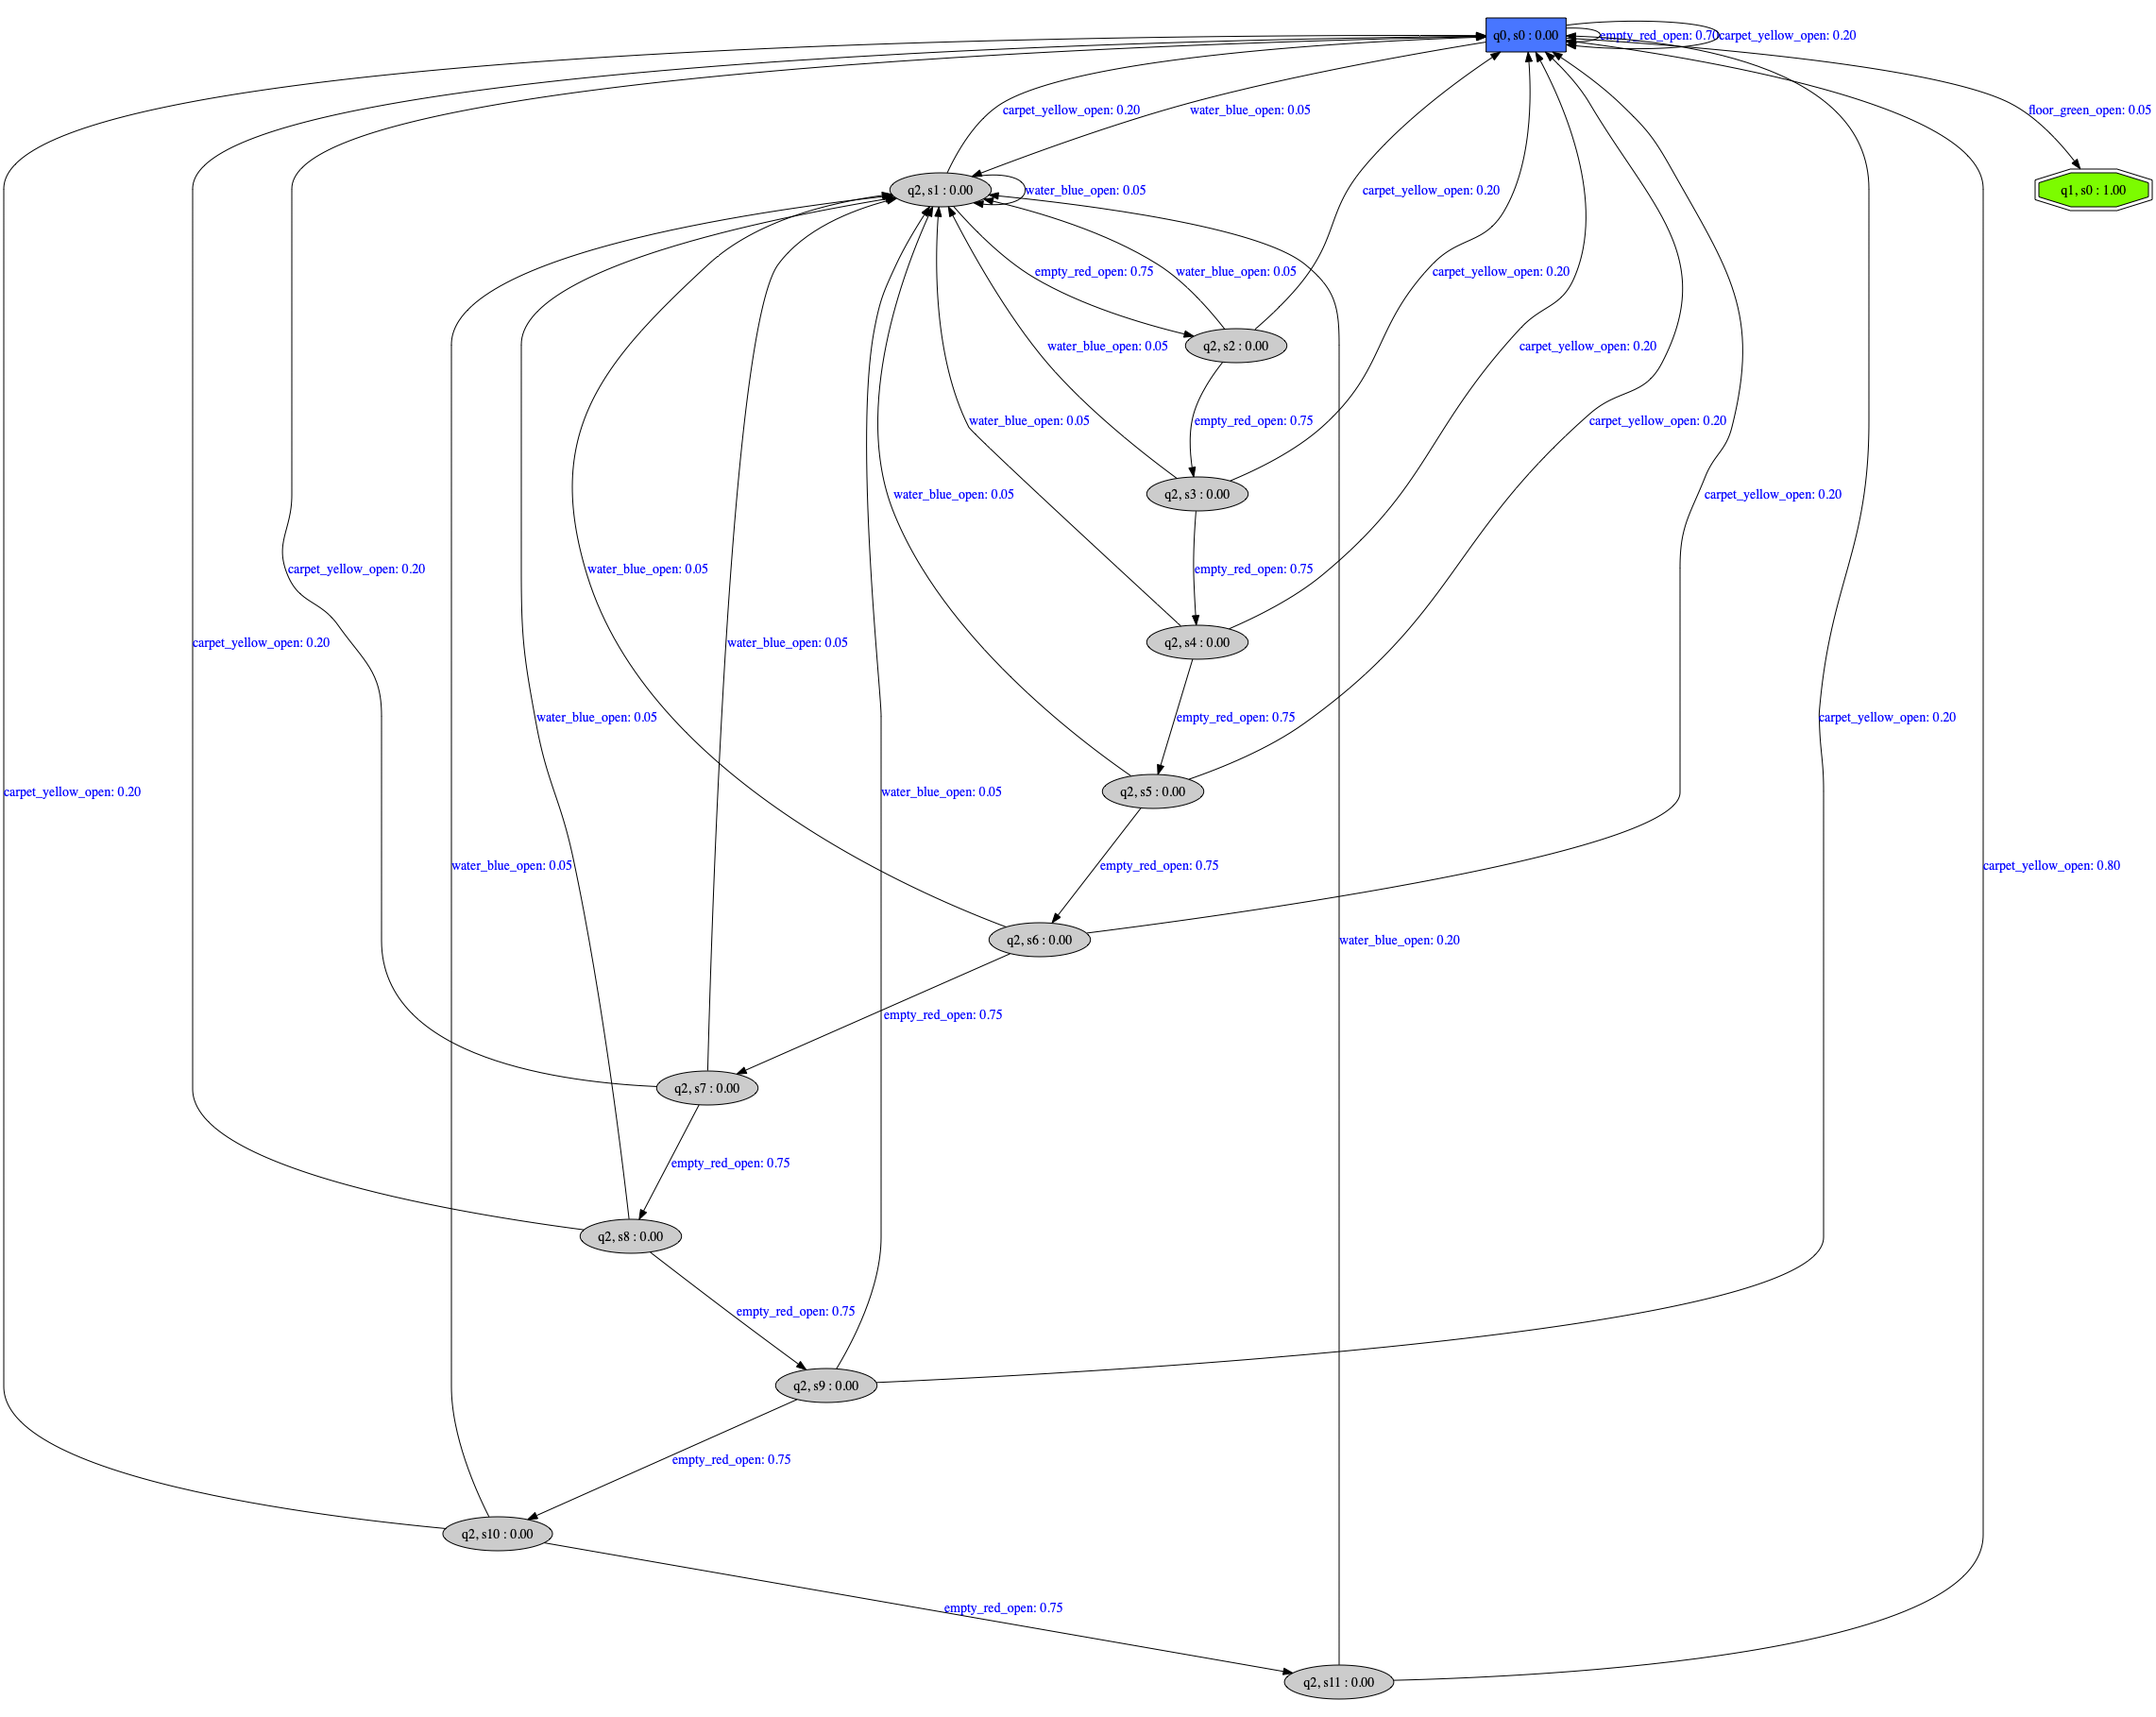

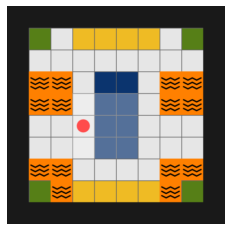

In [7]:
# env

experiment_name = 'safe_pdfa_learning_performance_analysis'
env_id = ENV_ID_1

pdfa_specification, safe_specification, minigrid_TS = load_automata_from_experiment(experiment_name, env_id, draw=True)

In [8]:
solve_environment(pdfa_specification, ENV_ID_1, actions_type='static')
solve_environment(pdfa_specification, ENV_ID_2, actions_type='static')
solve_environment(pdfa_specification, ENV_ID_1, actions_type='diag_static')
solve_environment(pdfa_specification, ENV_ID_2, actions_type='diag_static')

using env: MiniGrid-LavaComparison_seshia-v0
using actions: static


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:720: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['left', 'forward', 'forward', 'forward', 'left', 'forward', 'forward', 'right', 'forward']
Probability of Generated TS Observations in Spec: 0.002017680349999999
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(3, 5), up', '(3, 4), up', '(3, 3), up', '(3, 2), up', '(3, 2), left', '(2, 2), left', '(1, 2), left', '(1, 2), up', '(1, 1), up']


using env: MiniGrid-LavaComparison_SeshiaOnlyWaterPath-v0
using actions: static


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:720: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['right', 'forward', 'forward', 'left', 'forward', 'forward', 'right', 'forward', 'left', 'forward', 'forward', 'forward']
Probability of Generated TS Observations in Spec: 1.6141442799999995e-05
['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'carpet_yellow_open', 'carpet_yellow_open', 'carpet_yellow_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(3, 5), down', '(3, 6), down', '(3, 7), down', '(3, 7), right', '(4, 7), right', '(5, 7), right', '(5, 7), down', '(5, 8), down', '(5, 8), right', '(6, 8), right', '(7, 8), right', '(8, 8), right']


using env: MiniGrid-LavaComparison_seshia-v0
using actions: diag_static


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:720: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['northeast', 'northwest', 'northeast', 'northwest', 'southwest', 'northwest']
Probability of Generated TS Observations in Spec: 0.00013781249999999997
['empty_red_open', 'water_blue_open', 'empty_red_open', 'empty_red_open', 'carpet_yellow_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(4, 4), right', '(3, 3), right', '(4, 2), right', '(3, 1), right', '(2, 2), right', '(1, 1), right']


using env: MiniGrid-LavaComparison_SeshiaOnlyWaterPath-v0
using actions: diag_static


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:720: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)



Optimal Controls: ['southwest', 'southeast', 'southeast', 'northeast', 'northeast', 'southeast', 'southeast']
Probability of Generated TS Observations in Spec: 0.0011764899999999997
['empty_red_open', 'empty_red_open', 'empty_red_open', 'carpet_yellow_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
['(3, 5), right', '(2, 6), right', '(3, 7), right', '(4, 8), right', '(5, 7), right', '(6, 6), right', '(7, 7), right', '(8, 8), right']


In [12]:
# Generate Datasets
datagenerator = TracesGenerator(pdfa_specification)
param_dict = {'num_samples': num_samples,
              'N': Ns}
datasets = datagenerator.generate_datasets(param_dict)

[<wombats.learning.dataload.Dataset object at 0x7fa466699d10>, <wombats.learning.dataload.Dataset object at 0x7fa46624e8d0>, <wombats.learning.dataload.Dataset object at 0x7fa4666ba910>, <wombats.learning.dataload.Dataset object at 0x7fa4666acc90>, <wombats.learning.dataload.Dataset object at 0x7fa4666e6390>, <wombats.learning.dataload.Dataset object at 0x7fa4666f5550>, <wombats.learning.dataload.Dataset object at 0x7fa4665f2290>, <wombats.learning.dataload.Dataset object at 0x7fa466704cd0>, <wombats.learning.dataload.Dataset object at 0x7fa4666ffa10>, <wombats.learning.dataload.Dataset object at 0x7fa466715e90>, <wombats.learning.dataload.Dataset object at 0x7fa4666bab10>, <wombats.learning.dataload.Dataset object at 0x7fa4661e85d0>, <wombats.learning.dataload.Dataset object at 0x7fa46163fc50>, <wombats.learning.dataload.Dataset object at 0x7fa4666cba50>, <wombats.learning.dataload.Dataset object at 0x7fa466680ed0>, <wombats.learning.dataload.Dataset object at 0x7fa466756c10>, <wombat

In [85]:
# Candidate learning algorithms and their hyperparameters
# estimators = [Vanilla(), Postprocess(), Preprocess(), TargetSpecification()]
estimators = [Vanilla(), Postprocess(safe_specification), Preprocess(safe_specification)]
param_dict = {'p': ['0.6', '5.0']}
# param_dict = [{'p': ['5.0']}

estimator = GridSearch(estimators, param_dict, LEARNER_DATA_DIR)
estimator.batchfit(datasets)

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99977  m99952  x8  x4  m99954  x4  m99948  x2  

found intermediate solution with 5 and 5 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 5 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99977  m99952  x9  x4  x4  x4  x4  x4  m99925  

found intermediate solution with 7 and 7 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 7 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfri

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99974  m99953  m99909  x13  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99970  m99963  m99955  x15  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99970  m99960  m99901  x17  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99972  m99906  x14  x8  x8  x8  m99891  x6  m99853  x4  m99919  

found intermediate solution with 7 and 7 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 7 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 wit

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99967  m99944  m99919  x21  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99966  m99963  m99940  x23  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99971  m99940  x20  x8  x8  x8  m99889  x6  m99853  x4  m99915  

found intermediate solution with 7 and 7 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 7 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 wit

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99967  m99945  x24  x8  x8  x8  x6  x4  m99995  x6  x4  x2  x2  m99966  x2  x1  x1  

found intermediate solution with 14 and 14 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 14 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99972  m99935  m99901  x32  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99958  x4790  m99951  m99947  m99947  x2104  x1908  x1258  x780  m99952  m99949  x688  m99964  m99946  x486  m99971  x308  x300  m99966  m99945  x258  m99951  m99945  m99944  x198  m99968  x120  m99950  x120  m99951  m99949  x142  m99966  m99941  x118  x114  m99964  m99955  x102  m99948  x150  m99968  m99954  x150  m99954  m99958  m99953

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99967  m99954  m99949  x37  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99967  m99957  m99946  x43  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99965  m99953  x36  x20  m99903  x16  m99915  x12  m99906  x8  m99843  x6  m99905  x2  x2  m99901  

found intermediate solution with 9 and 9 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 9 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a4

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99964  m99954  x38  x22  m99964  x22  m99960  x14  m99981  x10  m99944  x10  m99948  m99956  x4  x3  x2  x2  x2  x2  x1  x1  

found intermediate solution with 15 and 15 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 15 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasa

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99965  m99932  x41  x24  m99902  x20  m99917  x16  m99891  x10  m99842  x8  m99904  x4  x4  m99901  x2  m99845  

found intermediate solution with 10 and 10 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 10 and 1 red states
No valid solver specified, skipping...

welcome, running git 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99963  m99946  x686  m99961  m99953  x300  x229  x86  m99942  x82  m99970  x60  m99977  m99964  m99952  x20  m99977  x18  x16  x14  x11  x8  m99967  x14  m99957  x7  x6  x4  x4  x4  x2  x2  x2  m99962  m99962  m99942  x2  x1  x1  

found intermediate solution with 25 and 25 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 25 and 1 red states
No valid solver

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99965  m99928  x48  x26  m99910  x22  m99902  x16  m99892  x10  m99843  x8  m99906  x4  x4  m99901  x2  m99846  

found intermediate solution with 10 and 10 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 10 and 1 red states
No valid solver specified, skipping...

welcome, running git 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99966  m99947  m99927  x70  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99963  m99951  m99902  x81  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  m99949  x70  x32  m99917  x26  m99890  x18  m99908  x10  m99851  x8  m99907  x4  x4  m99903  x2  m99853  

found intermediate solution with 10 and 10 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 10 and 1 red states
No valid solver specified, skipping...

welcome, running git 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99951  m99928  x93  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  x1660  m99954  m99948  m99947  x719  x686  x448  x274  m99967  m99963  x258  m99972  m99963  m99942  x166  m99952  x119  x106  m99970  m99957  x84  x74  m99972  m99986  m99957  m99944  x94  m99955  x58  x56  m99981  m99943  x62  m99970  x58  m99946  x46  m99948  x50  m99944  x62  m99964  m99952  x36  x36  m99993  m99971  x42  x28 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99954  m99947  x100  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99944  m99902  x613  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  m99954  x1849  x610  m99926  m99921  x394  m99915  m99906  x260  m99925  m99923  x164  m99928  m99902  x110  m99916  m99896  x60  m99881  x50  m99900  m99881  x32  m99905  m99903  x14  m99842  x8  m99926  x6  m99842  

found intermediate solution with 13 and 13 red states
No valid solver specified, skipping...
dfasat running
 

fo

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99957  m99949  x10966  m99950  x6088  m99956  m99954  m99944  x3843  x2702  x2033  x1496  m99958  m99944  x1496  m99959  x1122  m99957  m99941  x528  x170  x66  m99985  m99951  m99948  x80  m99963  x52  m99982  m99965  x36  m99967  x28  m99950  x42  m99951  x42  m99942  x28  m99997  x18  m99947  m99962  x14  m99995  m99974  x14  m99983  x9  x8  x8  m99956  x8  x6  x6  m99990  m99965  x6  x5  x5  x5  x5  

fo

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99969  m99951  x94  x40  m99922  x32  m99892  x24  m99919  x10  m99847  x8  m99904  x4  x4  m99903  x2  m99848  

found intermediate solution with 10 and 10 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 10 and 1 red states
No valid solver specified, skipping...

welcome, running git 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99961  m99943  m99934  x1149  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=k

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99967  m99959  m99941  x141  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99943  x567  x180  x124  m99953  x92  m99971  m99970  m99951  x74  m99973  x104  x60  m99953  m99942  x44  m99978  x38  m99966  x46  m99961  x40  m99953  x36  m99955  m99972  x22  x20  m99990  x22  m99944  x18  m99947  x16  x13  x12  x12  x11  x10  x10  m99965  x16  m99941  x20  m99959  m99966  x10  m99945  x14  m99945  x10  x8  

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99966  m99954  m99942  x162  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99959  m99951  x145  x58  m99924  x48  m99930  x34  m99923  x16  m99846  x14  m99908  x6  x6  m99903  x4  m99883  

found intermediate solution with 10 and 10 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 10 and 1 red states
No valid solver specified, skipping...

welcome, running gi

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99954  x232  m99955  m99944  x105  x71  x22  x18  m99959  x14  m99970  x14  x8  m99950  x8  m99945  m99959  m99952  x4  x4  x1  x1  x1  

found intermediate solution with 15 and 15 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 15 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99943  x611  x188  m99927  m99911  x140  m99925  m99918  x88  m99910  x54  m99895  m99889  x46  m99893  x26  m99905  x22  m99893  x12  m99885  x6  m99906  x2  m99926  

found intermediate solution with 12 and 12 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 12 and 1 red state

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99959  m99947  x3842  m99951  m99947  x1655  x1353  x532  m99968  m99943  x532  m99957  x404  m99964  m99942  x320  m99946  x132  m99971  m99958  x91  x88  m99941  x57  x50  m99978  x42  x32  m99974  m99943  x32  m99978  m99950  x34  m99987  m99950  x42  x30  m99964  x22  m99983  m99951  x20  x18  x13  x11  x8  m99994  x12  m99999  m99948  x20  m99979  m99953  x10  x6  x4  m99979  x4  x4  x3  x3  

found int

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  x1264  m99952  m99950  x626  m99961  m99945  x516  x492  m99952  m99944  x402  m99948  x346  m99968  m99963  x310  m99956  x376  m99956  m99950  m99942  m99951  x274  x200  m99954  x175  x124  m99962  m99958  x104  m99974  m99962  x88  m99946  x84  m99988  m99953  x78  m99955  x72  m99945  x64  x62  m99977  m99955  x66  m99968  m9

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  m99939  x1508  x478  m99925  m99923  x318  m99914  m99914  x198  m99920  m99915  x124  m99919  m99904  x84  m99922  m99896  x44  m99805  x36  m99900  x20  m99906  m99894  x8  m99903  x4  m99926  x2  m99884  

found intermediate solution with 13 and 13 red states
No valid solver specified, skipping...
dfasat running
 

found interm

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99957  m99945  x6294  m99951  m99948  x2711  x2189  x872  m99960  m99948  x872  m99962  x650  m99954  x372  m99963  m99951  x360  m99949  x264  m99949  m99946  x186  m99965  m99951  m99943  m99968  x99  x75  x70  m99955  m99953  x69  x58  m99970  m99951  x54  x47  x42  x30  m99973  m99958  x36  m99958  x30  m99986  m99948  x48  m99954  x40  m99947  x34  x20  m99977  x14  x10  x8  x6  m99943  m99962  m99986  

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99958  m99941  x196  x70  x56  m99952  x38  m99967  x48  m99983  m99950  x22  x22  x18  x12  m99978  x6  x6  m99953  x6  m99966  m99945  x7  x4  x4  x4  m99954  x8  m99941  m99989  x6  x2  x2  x2  x2  x2  x2  m99966  m99983  x4  x4  x4  x4  x2  

found intermediate solution with 30 and 30 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99961  m99942  x656  x200  m99966  m99944  x200  m99966  x166  m99949  m99950  x132  m99942  x112  m99958  x88  m99962  x72  x38  m99951  m99956  x22  x17  x14  x14  m99957  x14  m99972  m99956  x18  x12  x12  x8  x8  x7  x4  x4  m99995  x6  m99975  x4  m99960  x6  m99966  m99957  m99955  m99949  x5  x4  m99957  m99957  x4  x1  x1  

found intermediate solution with 31 and 31 red states
No valid solver speci

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  m99946  m99935  x247  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  m99953  x1986  x648  m99926  m99922  x420  m99917  m99905  x278  m99924  m99921  x176  m99928  m99905  x120  m99908  m99896  x66  m99896  x52  m99900  m99881  x34  m99905  m99903  x16  m99843  x10  m99926  x8  m99882  m99843  

found intermediate solution with 13 and 13 red states
No valid solver specified, skipping...
dfasat runn

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99957  m99948  x11722  m99951  m99942  x7352  m99954  m99945  x6304  m99952  m99950  x5376  m99953  m99943  x4139  x2429  x2185  x524  x518  m99948  x464  x318  m99956  m99955  m99941  x518  m99970  x352  m99965  m99945  x272  m99956  m99942  x104  x81  x76  x50  x42  m99982  x27  x26  m99945  m99943  m99981  x16  x14  x6  x4  m99957  x3  

found intermediate solution with 27 and 27 red states
No valid solve

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  x304  m99958  m99946  m99944  x137  x106  x82  x62  m99953  x40  m99957  x58  m99976  m99952  x26  x22  x18  x12  m99978  x6  x6  m99953  x6  m99966  m99945  x7  x6  x6  x4  m99954  x8  m99960  m99941  x8  x4  m99943  x2  x2  x2  x2  x2  x2  m99966  m99951  x2  m99958  x1  

found intermediate solution with 30 and 30 red states
No

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99959  m99947  x1526  m99954  m99946  x656  x558  x214  m99951  x200  m99965  m99949  m99957  x93  x28  m99963  x26  x18  m99970  m99950  x8  x8  x8  x4  m99960  x6  m99950  x2  x2  x2  m99950  x1  x1  x1  

found intermediate solution with 21 and 21 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 21 and 1 red states
No valid solver specified, skipping...


welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  m99941  x698  x226  m99955  m99944  x226  m99971  x192  m99948  m99950  x148  m99949  x112  m99965  x92  m99955  x78  x32  m99957  x30  m99968  x22  x20  x16  x15  x14  x10  m99954  x10  x8  m99948  x12  m99970  x12  m99983  m99966  x18  m99956  x10  m99956  m99964  m99955  x10  x8  x7  x4  x4  x2  m99991  m99970  x2  

found intermediate solution with 30 and 30 red states
No valid solver specified, s

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99940  x261  x88  m99932  x68  m99921  m99846  x44  m99923  x24  m99869  x20  m99881  x6  x6  m99902  x4  m99878  

found intermediate solution with 10 and 10 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 10 and 1 red states
No valid solver specified, skipping...

welcome, ru

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99958  m99949  x2166  m99954  m99948  x933  x790  x300  m99962  x278  m99951  x108  x76  x64  m99968  m99954  x68  m99961  m99958  x42  m99965  x38  m99965  m99942  m99967  x58  x30  m99963  x22  m99976  m99947  x36  m99948  x32  x18  m100000  x18  m99983  x14  x14  x8  x8  x6  x6  x6  x4  x4  x4  m99981  m99979  x3  x3  x2  x1  x1  

found intermediate solution with 34 and 34 red states
No valid solver spec

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99964  m99942  x302  x98  x74  m99947  x46  m99956  x64  m99975  m99973  m99954  x28  x28  x24  x14  m99963  x12  m99949  x10  x10  x8  m99965  m99944  x14  x10  m99948  x8  m99947  x10  m99955  x6  m99992  x8  m99960  m99998  x6  x6  m99942  x8  x5  x4  x2  x2  x2  m99966  m99954  x2  x2  x2  x2  m99945  x2  x2  x2  x2  x2  x2  m99966  

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99940  x746  x246  m99925  m99902  x176  m99924  m99916  x114  m99904  x76  m99899  m99897  x58  m99915  m99895  x30  m99905  x26  m99908  x14  m99906  m99885  x6  m99905  x2  m99926  

found intermediate solution with 12 and 12 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 1

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99946  m99938  x376  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99961  x1440  m99953  m99946  x730  m99955  m99948  x598  x574  m99950  m99941  x472  m99953  x400  m99965  m99955  x354  m99962  x430  m99970  m99954  m99941  m99954  x306  x224  m99947  x201  x136  m99970  m99958  x118  m99971  m99965  x100  x92  m99987  m99957  x74  x68  m99977  m99959  m99946  x106  m99944  x92  m99944  m99957  x63  

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99956  m99938  x6526  x2076  m99933  m99916  x1408  m99924  m99916  x932  m99919  m99917  x582  m99930  m99911  x362  m99916  m99907  x222  m99931  m99919  x128  m99915  m99881  x92  m99904  m99903  x52  m99913  x28  m99929  x24  m99905  m99865  

found intermediate solution with 13 and 13 red states
No valid solver specified, skipping..

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99947  m99941  x403  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99961  m99940  x803  x258  m99923  m99909  x184  m99922  m99916  x122  m99904  x84  m99907  m99897  x60  m99915  m99899  x32  m99905  x28  m99908  x16  m99905  m99889  x6  m99905  x2  m99926  

found intermediate solution with 12 and 12 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 1

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99956  m99949  m99932  x8111  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99961  m99943  x369  x126  x92  m99953  x64  m99981  m99973  m99942  x56  x34  x30  m99978  x36  m99957  x27  x24  x16  x16  x14  m99969  m99953  x16  m99946  x22  x22  m99951  x24  m99980  x10  x8  x8  m99973  m99951  x10  x9  x8  m99977  m99960  x6  x6  x6  x4  m100000  x4  x4  m99944  x4  m99945  m99949  m99972  x4  m99973  x3  x2  x2

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99959  m99948  x4088  m99950  m99947  x1763  x1467  x562  m99968  m99944  x562  m99961  x422  m99964  x244  m99955  x246  m99953  m99947  x150  m99943  x108  m99981  m99954  x63  x58  m99948  x78  m99966  m99964  x82  m99969  m99967  x48  m99976  x43  x29  x28  m99943  m99947  x32  m99988  x25  x23  x22  m99975  m99953  m99945  x32  x24  m99973  m99942  m99941  x21  x18  x16  x16  m99957  m99942  m99947  m99

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99958  m99945  x4732  m99948  m99945  m99942  x2366  x1671  

found intermediate solution with 4 and 4 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 4 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99961  m99945  x401  x126  m99923  m99858  x96  m99918  m99908  x62  m99913  x38  m99869  x34  m99890  x18  x18  m99869  x12  m99886  x6  m99904  x2  m99925  

found intermediate solution with 12 and 12 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 12 and 1 red states
No valid solver

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99962  m99944  m99933  x1000  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99958  m99949  m99932  x3053  

found intermediate solution with 2 and 2 red states
No valid solver specified, skipping...
dfasat running
 

found intermediate solution with 2 and 1 red states
No valid solver specified, skipping...

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=k

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=5.0 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99960  m99939  x1308  x422  m99931  m99918  x278  m99915  m99914  x174  m99915  m99915  x112  m99905  m99897  x78  m99921  m99896  x42  m99854  x36  m99899  x20  m99906  m99894  x8  m99903  x4  m99926  x2  m99885  

found intermediate solution with 13 and 13 red states
No valid solver specified, skipping...
dfasat running
 

found interm

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99956  m99945  x7254  m99951  m99949  x3124  x2508  x1006  m99960  m99948  x1006  m99960  x756  m99951  m99943  x576  m99961  x320  m99963  m99944  m99945  x220  m99974  m99942  x144  m99951  m99947  x113  x100  x79  x75  x52  m99965  m99944  x76  m99964  m99943  x50  x44  m99979  m99958  x46  m99955  x38  x36  m99988  m99968  x36  x22  x16  m99971  m99961  x22  m100000  m99974  x12  x12  x11  x7  x7  x6  x4

welcome, running git commit 8116712a49320fc82a32a6478ffaa3e48719e3e6 with: dfasat/flexfringe -S=wombats/config/DFA_safe_pdfa_learning_performance_analysis.yaml -h=kldistance -d=kl_data -n=2 -x=0 -w=0 -b=1 -f=1 -I=0 -t=1 -l=0 -q=0 -y=0 -T=1 -p=0.6 -C=0 --output-dir=experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/dfa /Users/kandai/Documents/projects/research/wombats_experiments/experiments/safe_pdfa_learning_performance_analysis/flexfringe_data/train.abbadingo 
sat_program : 
valid: kldistance
Using heuristic kldistance
Creating apta using evaluation class kl_data
batch mode selected
reading data finished, processing:
dfasat running
 m99956  x9028  m99955  m99950  m99951  x3956  x3563  x2356  x1454  m99958  m99952  x1286  m99955  x1036  m99949  m99946  x916  m99966  m99949  m99944  m99947  x612  x562  m99963  x374  m99949  x350  m99966  x436  m99955  x238  m99962  m99956  m99946  x306  m99971  x222  m99976  m99957  x308  m99992  m99961  x246  m99955  m99942  m99953  x

In [91]:
evaluation = Evaluator(DefaultEvaluationFunctions(safe_specification), output_directory=ANALYSIS_DATA_DIR)
evaluation.evaluate(estimator)
evaluation._df

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q2, s1) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q2, s3) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q2, s6) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q2, s11) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:2

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q718, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q718, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q197) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q773) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:21

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q1623) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q1623) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q154) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q154) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: U

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q120) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q120) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q60) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q60) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:21

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q120) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q120, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q120, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q47) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdf

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q1184) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q3918) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q3665) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: Use

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q959) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q3466) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q959) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q3466) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211:

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q153) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q398) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q194) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q398) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarni

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q4434, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q4434, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q1897) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q1897) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.p

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q975) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q45) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q975) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q45) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q180) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q1302) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q180) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q153) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q198) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q198) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWar

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q2908) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q3603) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q2908, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q3603, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pd

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q43) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q1207) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q1209) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q1210) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: Us

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q1189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q196) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q1488) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q1505) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: User

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q128, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q471, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q23, s2) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q46) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q748) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q748) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q748, s6) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q748, s6) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q152) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q801) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q152) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q1678) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWa

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q1708) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q1187) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q791) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q1708) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: Us

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q4975) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q4975) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q4975, s1) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (carpet_yellow_open) is not found in the curr_state's (q4975, s1) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automa

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q1822, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q716, s4) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q1822, s0) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q716, s4) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:211: UserWarning: given symbol (water_blue_open) is not found in the curr_state's (q152) transition distribution
  warnings.warn(str(e))


estimator          clf    p   N  \
0    Vanilla(I='0', T='1', b='1', d='kl_data',\n   ...      Vanilla  0.6  20   
1    Vanilla(I='0', T='1', b='1', d='kl_data',\n   ...      Vanilla  5.0  20   
2    Postprocess(I='0', T='1', b='1', d='kl_data',\...  Postprocess  0.6  20   
3    Postprocess(I='0', T='1', b='1', d='kl_data',\...  Postprocess  5.0  20   
4    Preprocess(I='0', T='1', b='1', d='kl_data',\n...   Preprocess  0.6  20   
..                                                 ...          ...  ...  ..   
589  Vanilla(I='0', T='1', b='1', d='kl_data',\n   ...      Vanilla  5.0  20   
590  Postprocess(I='0', T='1', b='1', d='kl_data',\...  Postprocess  0.6  20   
591  Postprocess(I='0', T='1', b='1', d='kl_data',\...  Postprocess  5.0  20   
592  Preprocess(I='0', T='1', b='1', d='kl_data',\n...   Preprocess  0.6  20   
593  Preprocess(I='0', T='1', b='1', d='kl_data',\n...   Preprocess  5.0  20   

     num_samples  Average True Forward KL  Average True Reverse KL  \
0             10                -0.042322                 0.029957   
1             10                -0.036218                 0.001593   
2             10                -0.042322                 0.004542   
3             10                -0.036218                -0.000544   
4             10                -0.042322                 0.030129   
..           ...                      ...                      ...   
589         8697                -0.007464                 0.002545   
590         8697                -0.005342                -0.006708   
591         8697                -0.007467                -0.004540   
592         8697                -0.006020                -0.005988   
593         8697                -0.010910                -0.000385   

     Average False Forward KL  Average False Reverse KL  \
0                   -0.024458                  0.066207   
1                   -0.001426                  0.053117   
2                   -0.004172                  0.066207   
3                    0.000651                  0.053117   
4                   -0.024633                  0.066207   
..                        ...                       ...   
589                  0.004589                  0.008745   
590                  0.007572                  0.005974   
591                  0.004891                  0.008746   
592                  0.006782                  0.006837   
593                  0.000387                  0.013586   

     L1 Norm of Trace Probabilities  L2 Norm of Trace Probabilities  \
0                          0.027905                        0.001722   
1                          0.015847                        0.000937   
2                          0.020004                        0.001378   
3                          0.015501                        0.000936   
4                          0.027958                        0.001722   
..                              ...                             ...   
589                        0.004394                        0.000069   
590                        0.004484                        0.000065   
591                        0.004474                        0.000070   
592                        0.004644                        0.000065   
593                        0.004370                        0.000118   

     No of Nodes  No of Edges  Elapsed Time  Safe  
0              4            8      0.010140     0  
1              2            4      0.008444     0  
2             14           27      0.008150     1  
3             13           36      0.007237     1  
4              8           11      0.011260     1  
..           ...          ...           ...   ...  
589            2            4      0.735744     0  
590           77          204      1.637254     1  
591           13           36      1.045429     1  
592           55          152      2.279483     1  
593           13           35      1.812728     1  

[594 rows x 15 columns]

x=num_samples, legend=['clf'], y=Average True Forward KL
x=num_samples, legend=['clf'], y=Average True Reverse KL
x=num_samples, legend=['clf'], y=Average False Forward KL
x=num_samples, legend=['clf'], y=Average False Reverse KL
x=num_samples, legend=['clf'], y=L1 Norm of Trace Probabilities
x=num_samples, legend=['clf'], y=L2 Norm of Trace Probabilities
x=num_samples, legend=['clf'], y=No of Nodes
x=num_samples, legend=['clf'], y=No of Edges
x=num_samples, legend=['clf'], y=Elapsed Time
x=num_samples, legend=['clf'], y=Safe


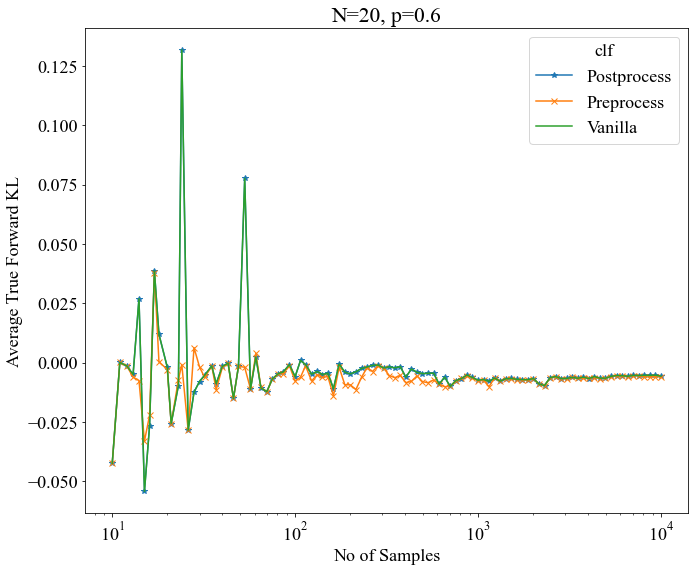

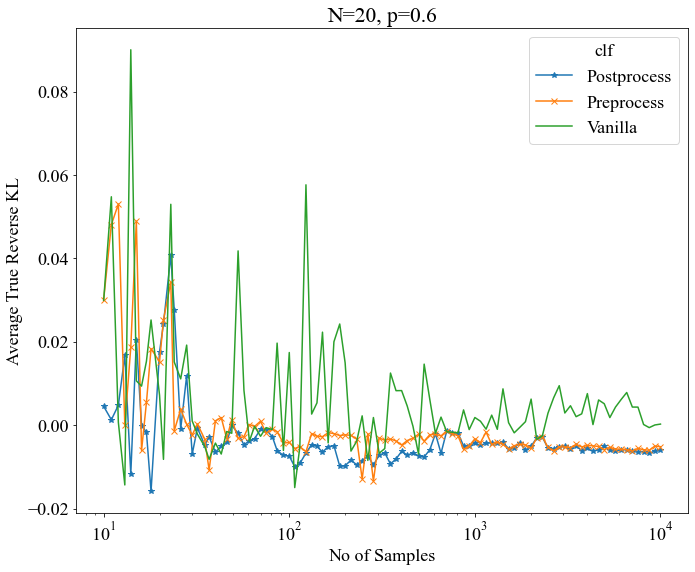

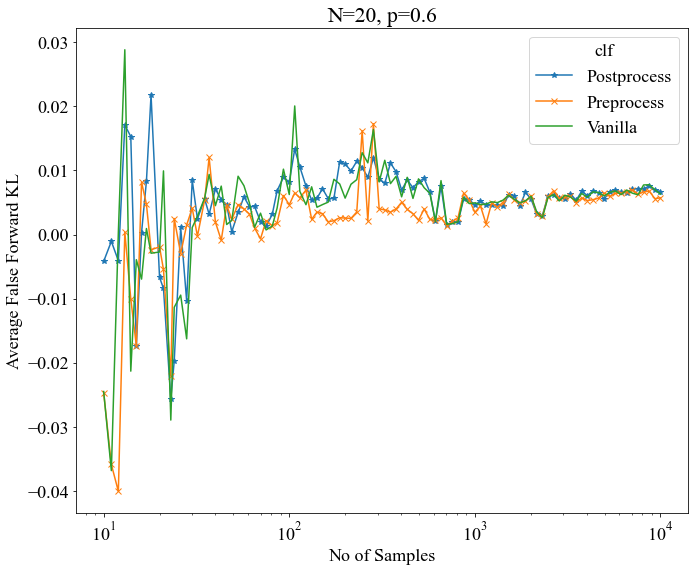

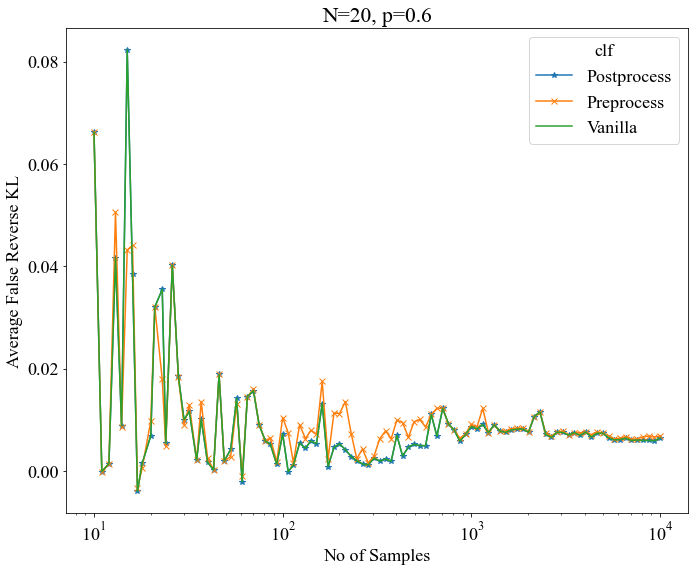

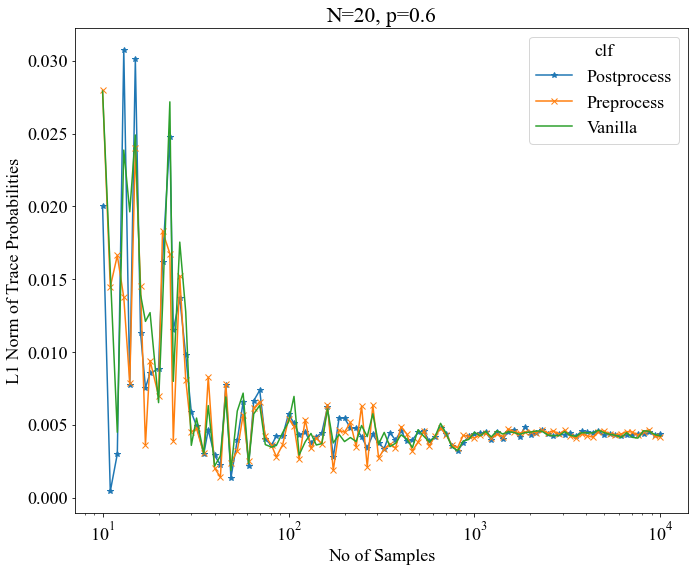

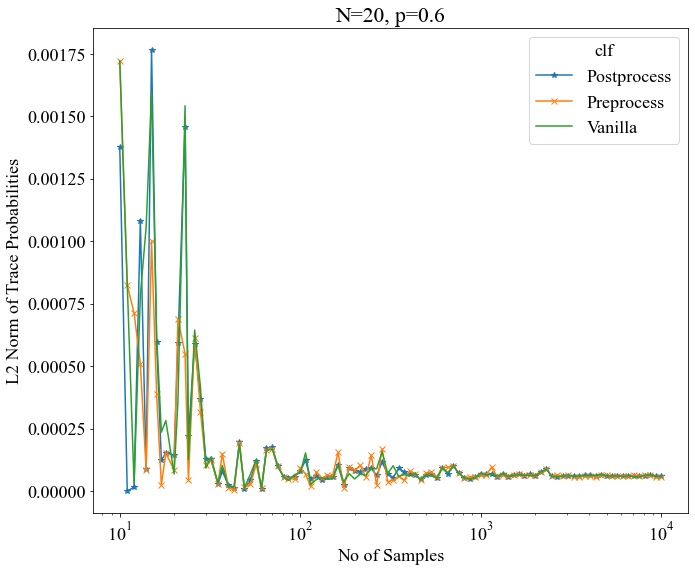

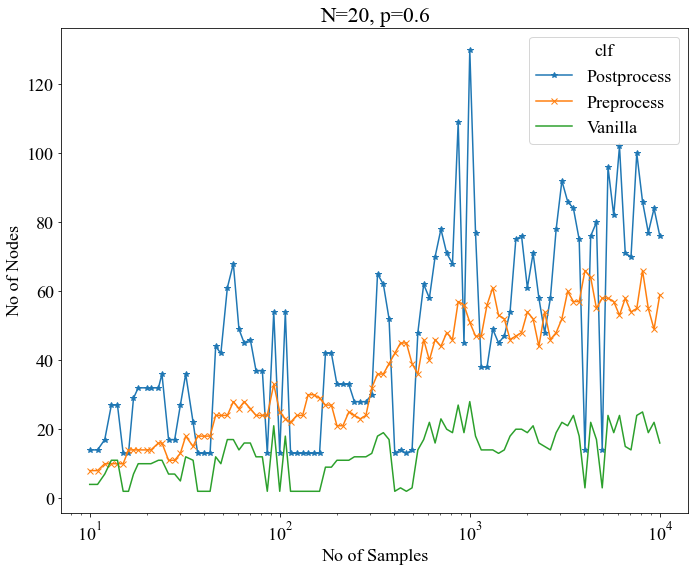

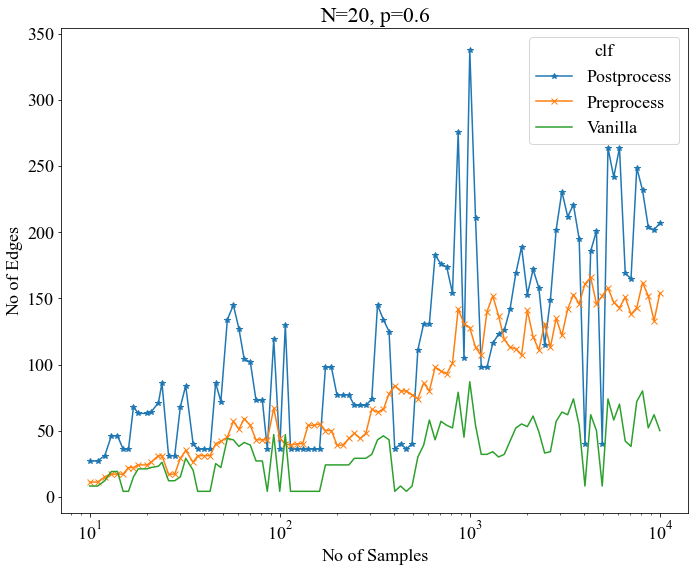

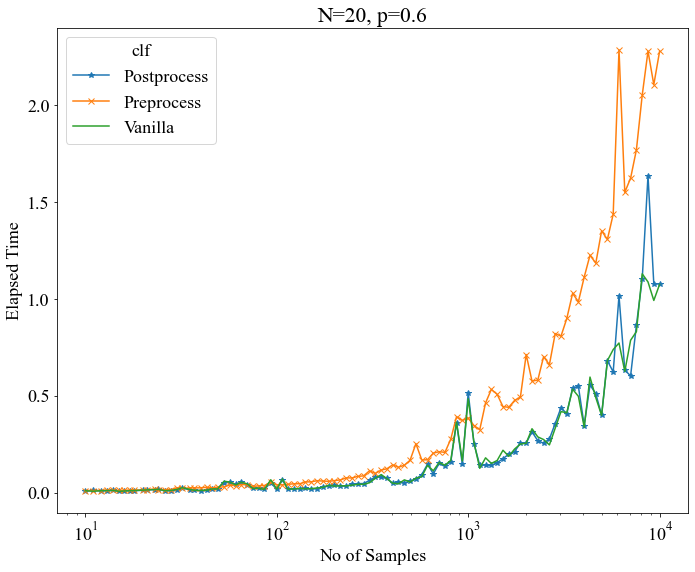

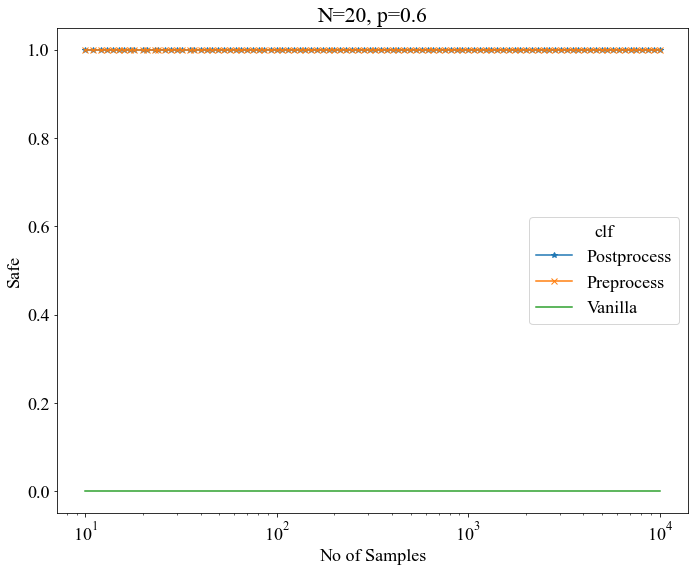

In [92]:
# Plot
evaluation.plot(selected_params={'p': '0.6'}, 
                figsize=(10, 8), 
                logx=True,
                style={'Preprocess': '-x', 'Postprocess': '-*'}
                # logy=True,
)

x=num_samples, legend=['clf'], y=Average True Forward KL
x=num_samples, legend=['clf'], y=Average True Reverse KL
x=num_samples, legend=['clf'], y=Average False Forward KL
x=num_samples, legend=['clf'], y=Average False Reverse KL
x=num_samples, legend=['clf'], y=L1 Norm of Trace Probabilities
x=num_samples, legend=['clf'], y=L2 Norm of Trace Probabilities
x=num_samples, legend=['clf'], y=No of Nodes
x=num_samples, legend=['clf'], y=No of Edges
x=num_samples, legend=['clf'], y=Elapsed Time
x=num_samples, legend=['clf'], y=Safe


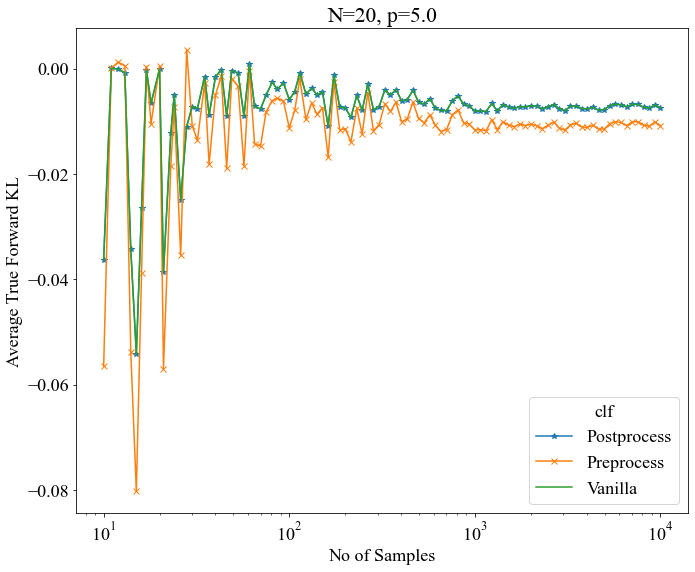

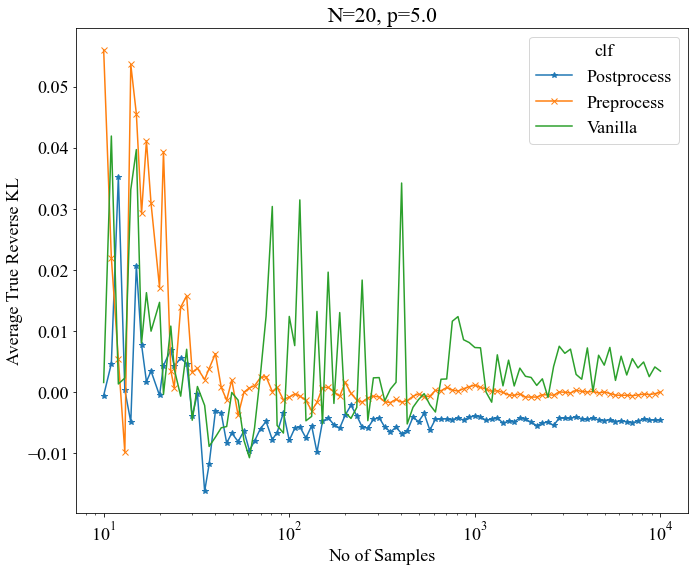

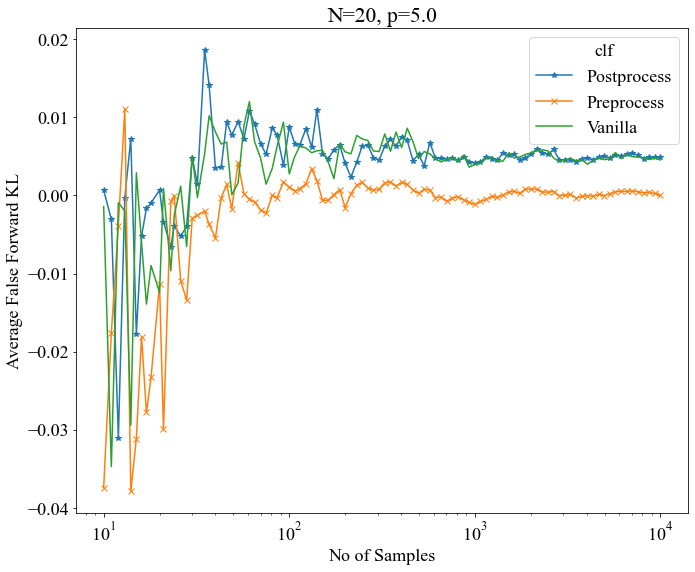

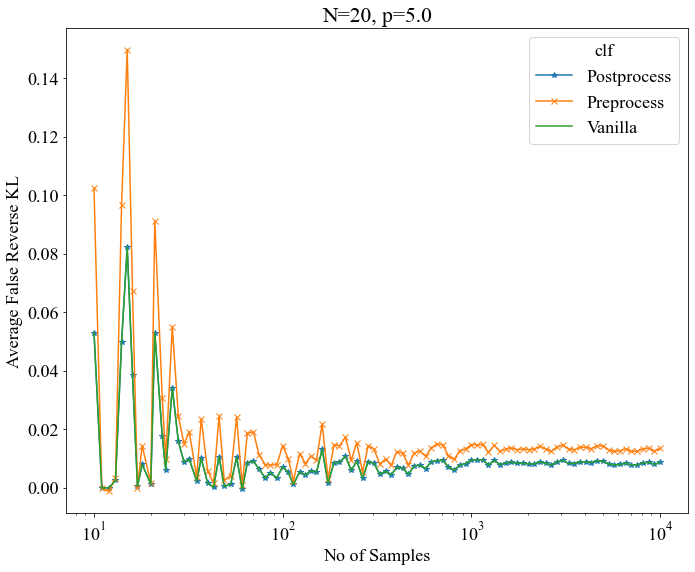

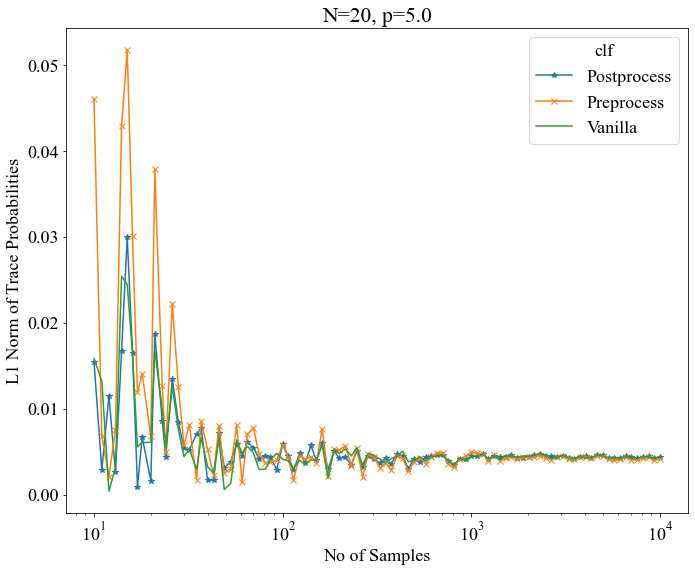

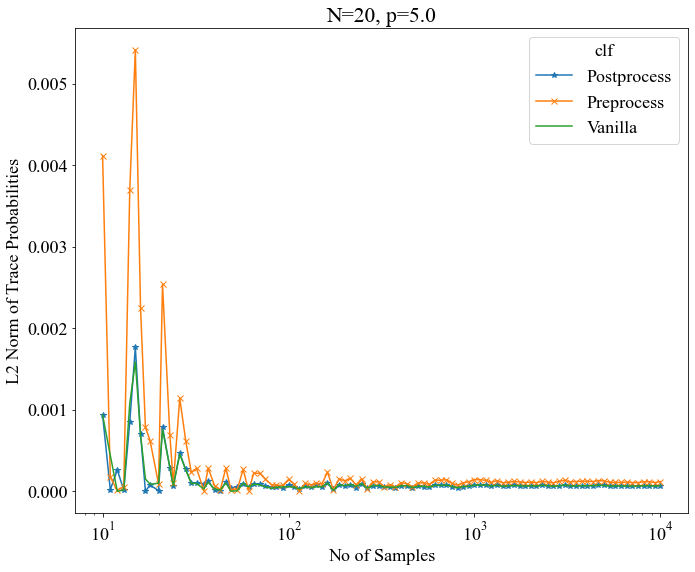

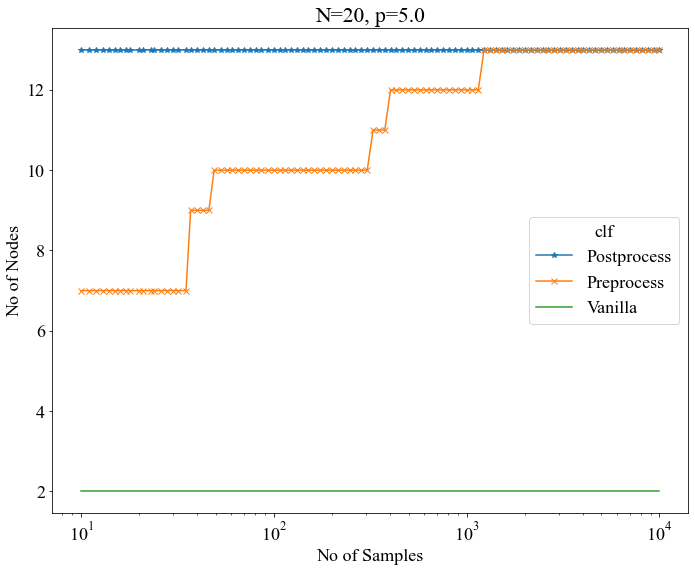

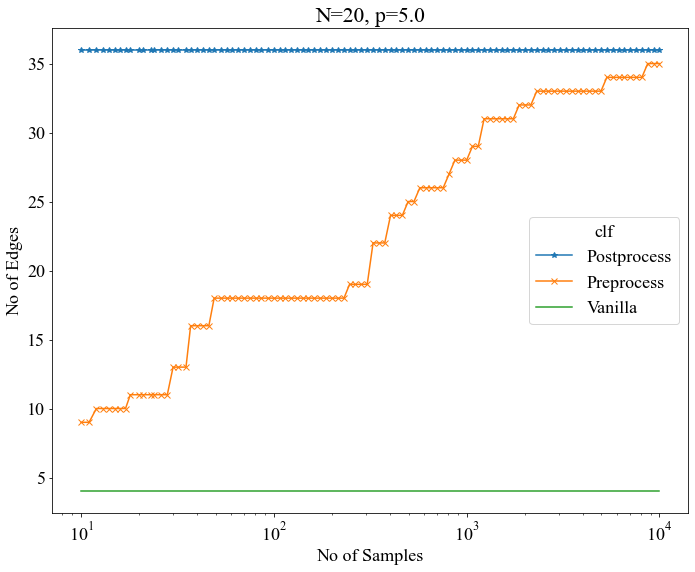

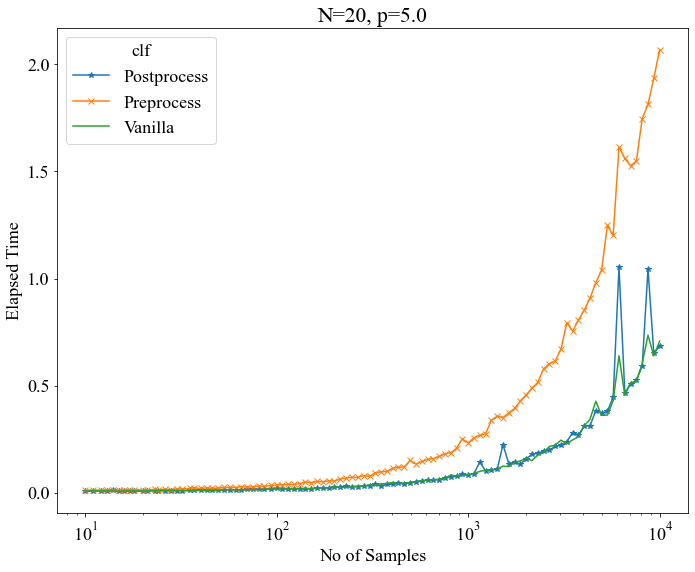

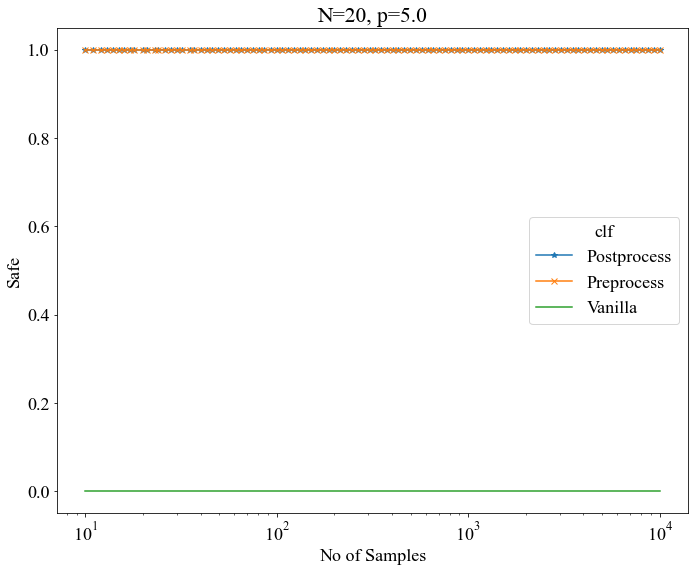

In [93]:
# Plot
evaluation.plot(selected_params={'p': '5.0'}, 
                figsize=(10, 8), 
                logx=True,
                style={'Preprocess': '-x', 'Postprocess': '-*'}
                # logy=True,
)

10000.0


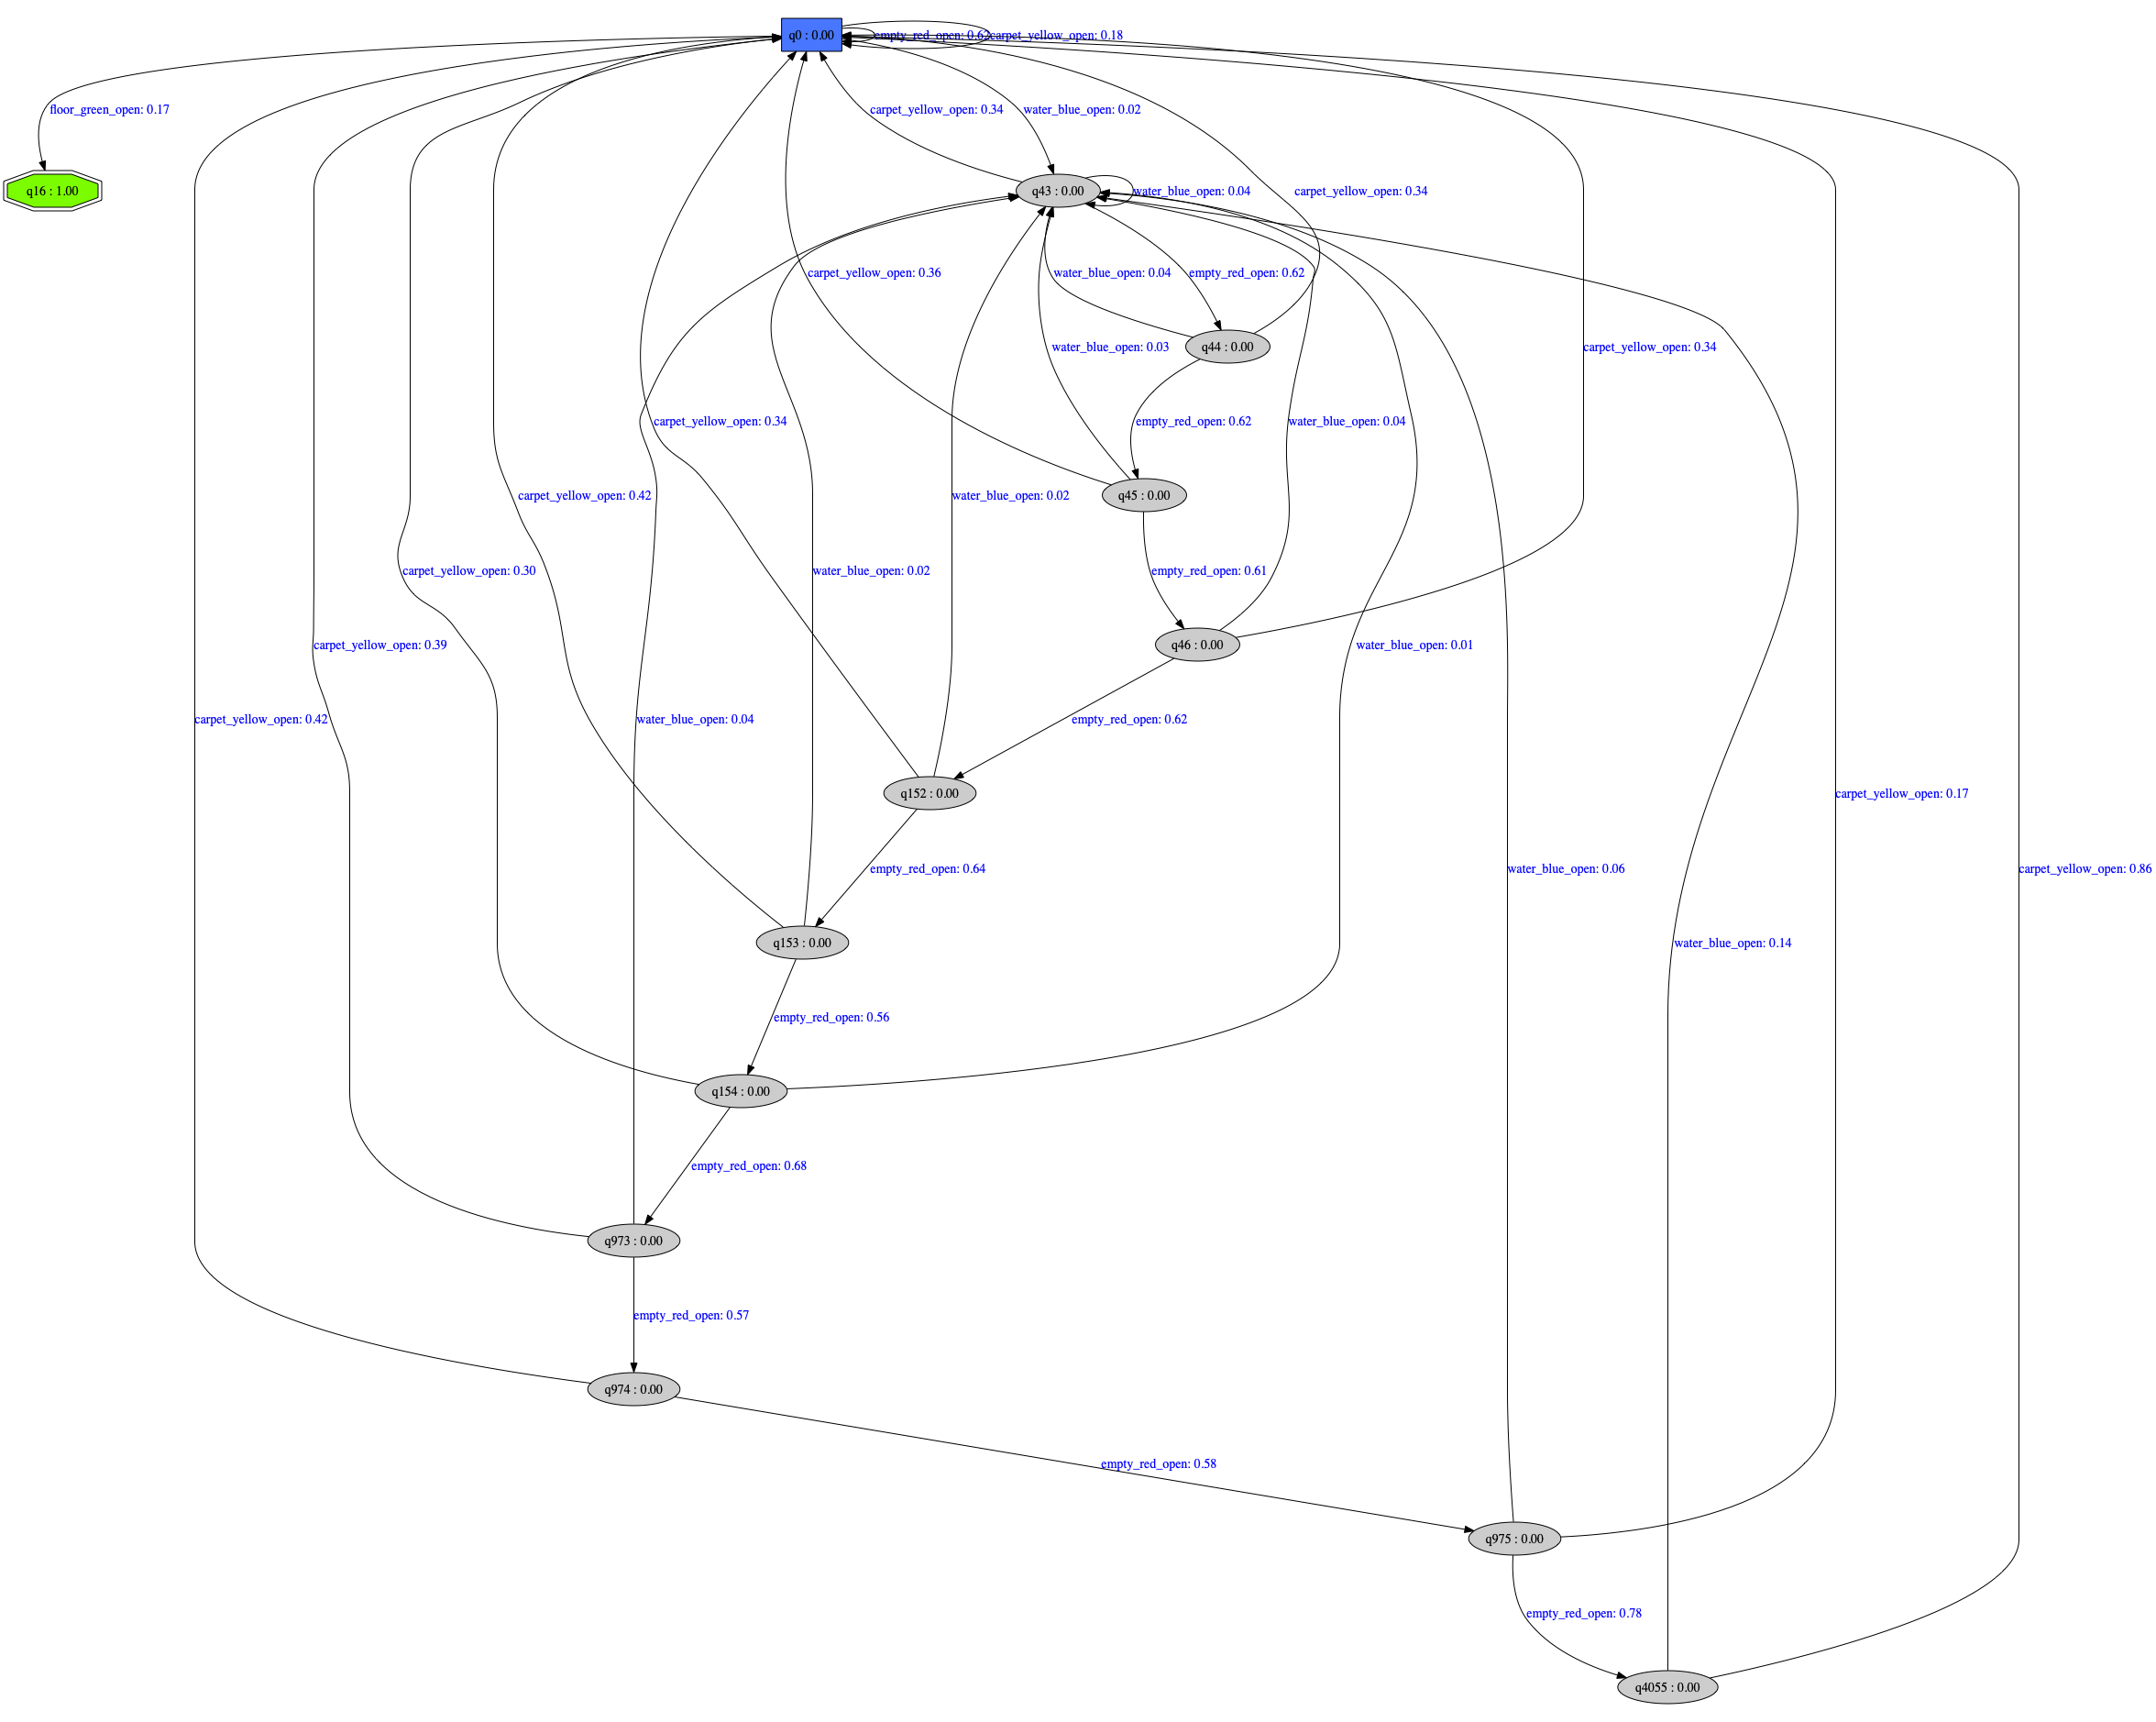

In [89]:
selected_params = {'p': '5.0',
                   'N': 20,
                   'clf': 'Preprocess',
#                    'clf': 'VanillaSL',
                   'num_samples': int(num_samples[-2])}
filename = '_'.join([EXPERIMENT_NAME, env_id, 'learnedPDFA'])
print(num_samples[-1])
evaluation.draw(
    selected_params, 
    filename=filename)

In [90]:
selected_params = {'p': '5.0',
                   'N': 20,
                   'clf': 'Preprocess',
#                    'clf': 'VanillaSL',
                   'num_samples': int(num_samples[-2])}

learned_pdfa = evaluation.pdfas(selected_params)


# Experiment 3: Control Synthesis

We now synthesize a controller with the learned PDFA $\mathcal{A}_{est}$ , given an transition system $\mathcal{T}$ 

$$ \mathcal{P} = \mathcal{A}_{est} \times \mathcal{T} $$

Any path from "accepting" states to the initial state (we don't have accepting states but rather "accepting probability") completes the task. However, we propose a smarter way: Most Probable String.

We want to find the Most Probable String (strategy) that reflects demonstrator's preferences. 

$$ \omega* = \arg \max Pr(\mathcal{P}(\omega) \quad s.t. \mathbb{F}_{(\mathcal{P}, \mathbb{P})} ( \delta_{(\mathcal{P}, \mathbb{W})} (\lambda, \omega )) > 0$$

using env: MiniGrid-LavaComparison_seshia-v0
using actions: simple_static


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/systems/minigrid.py:720: RuntimeWarning: could not find any goal objects.
  warnings.warn(msg, RuntimeWarning)


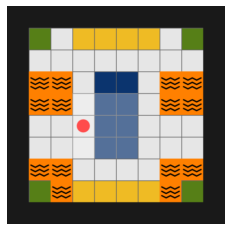

underlying transition system


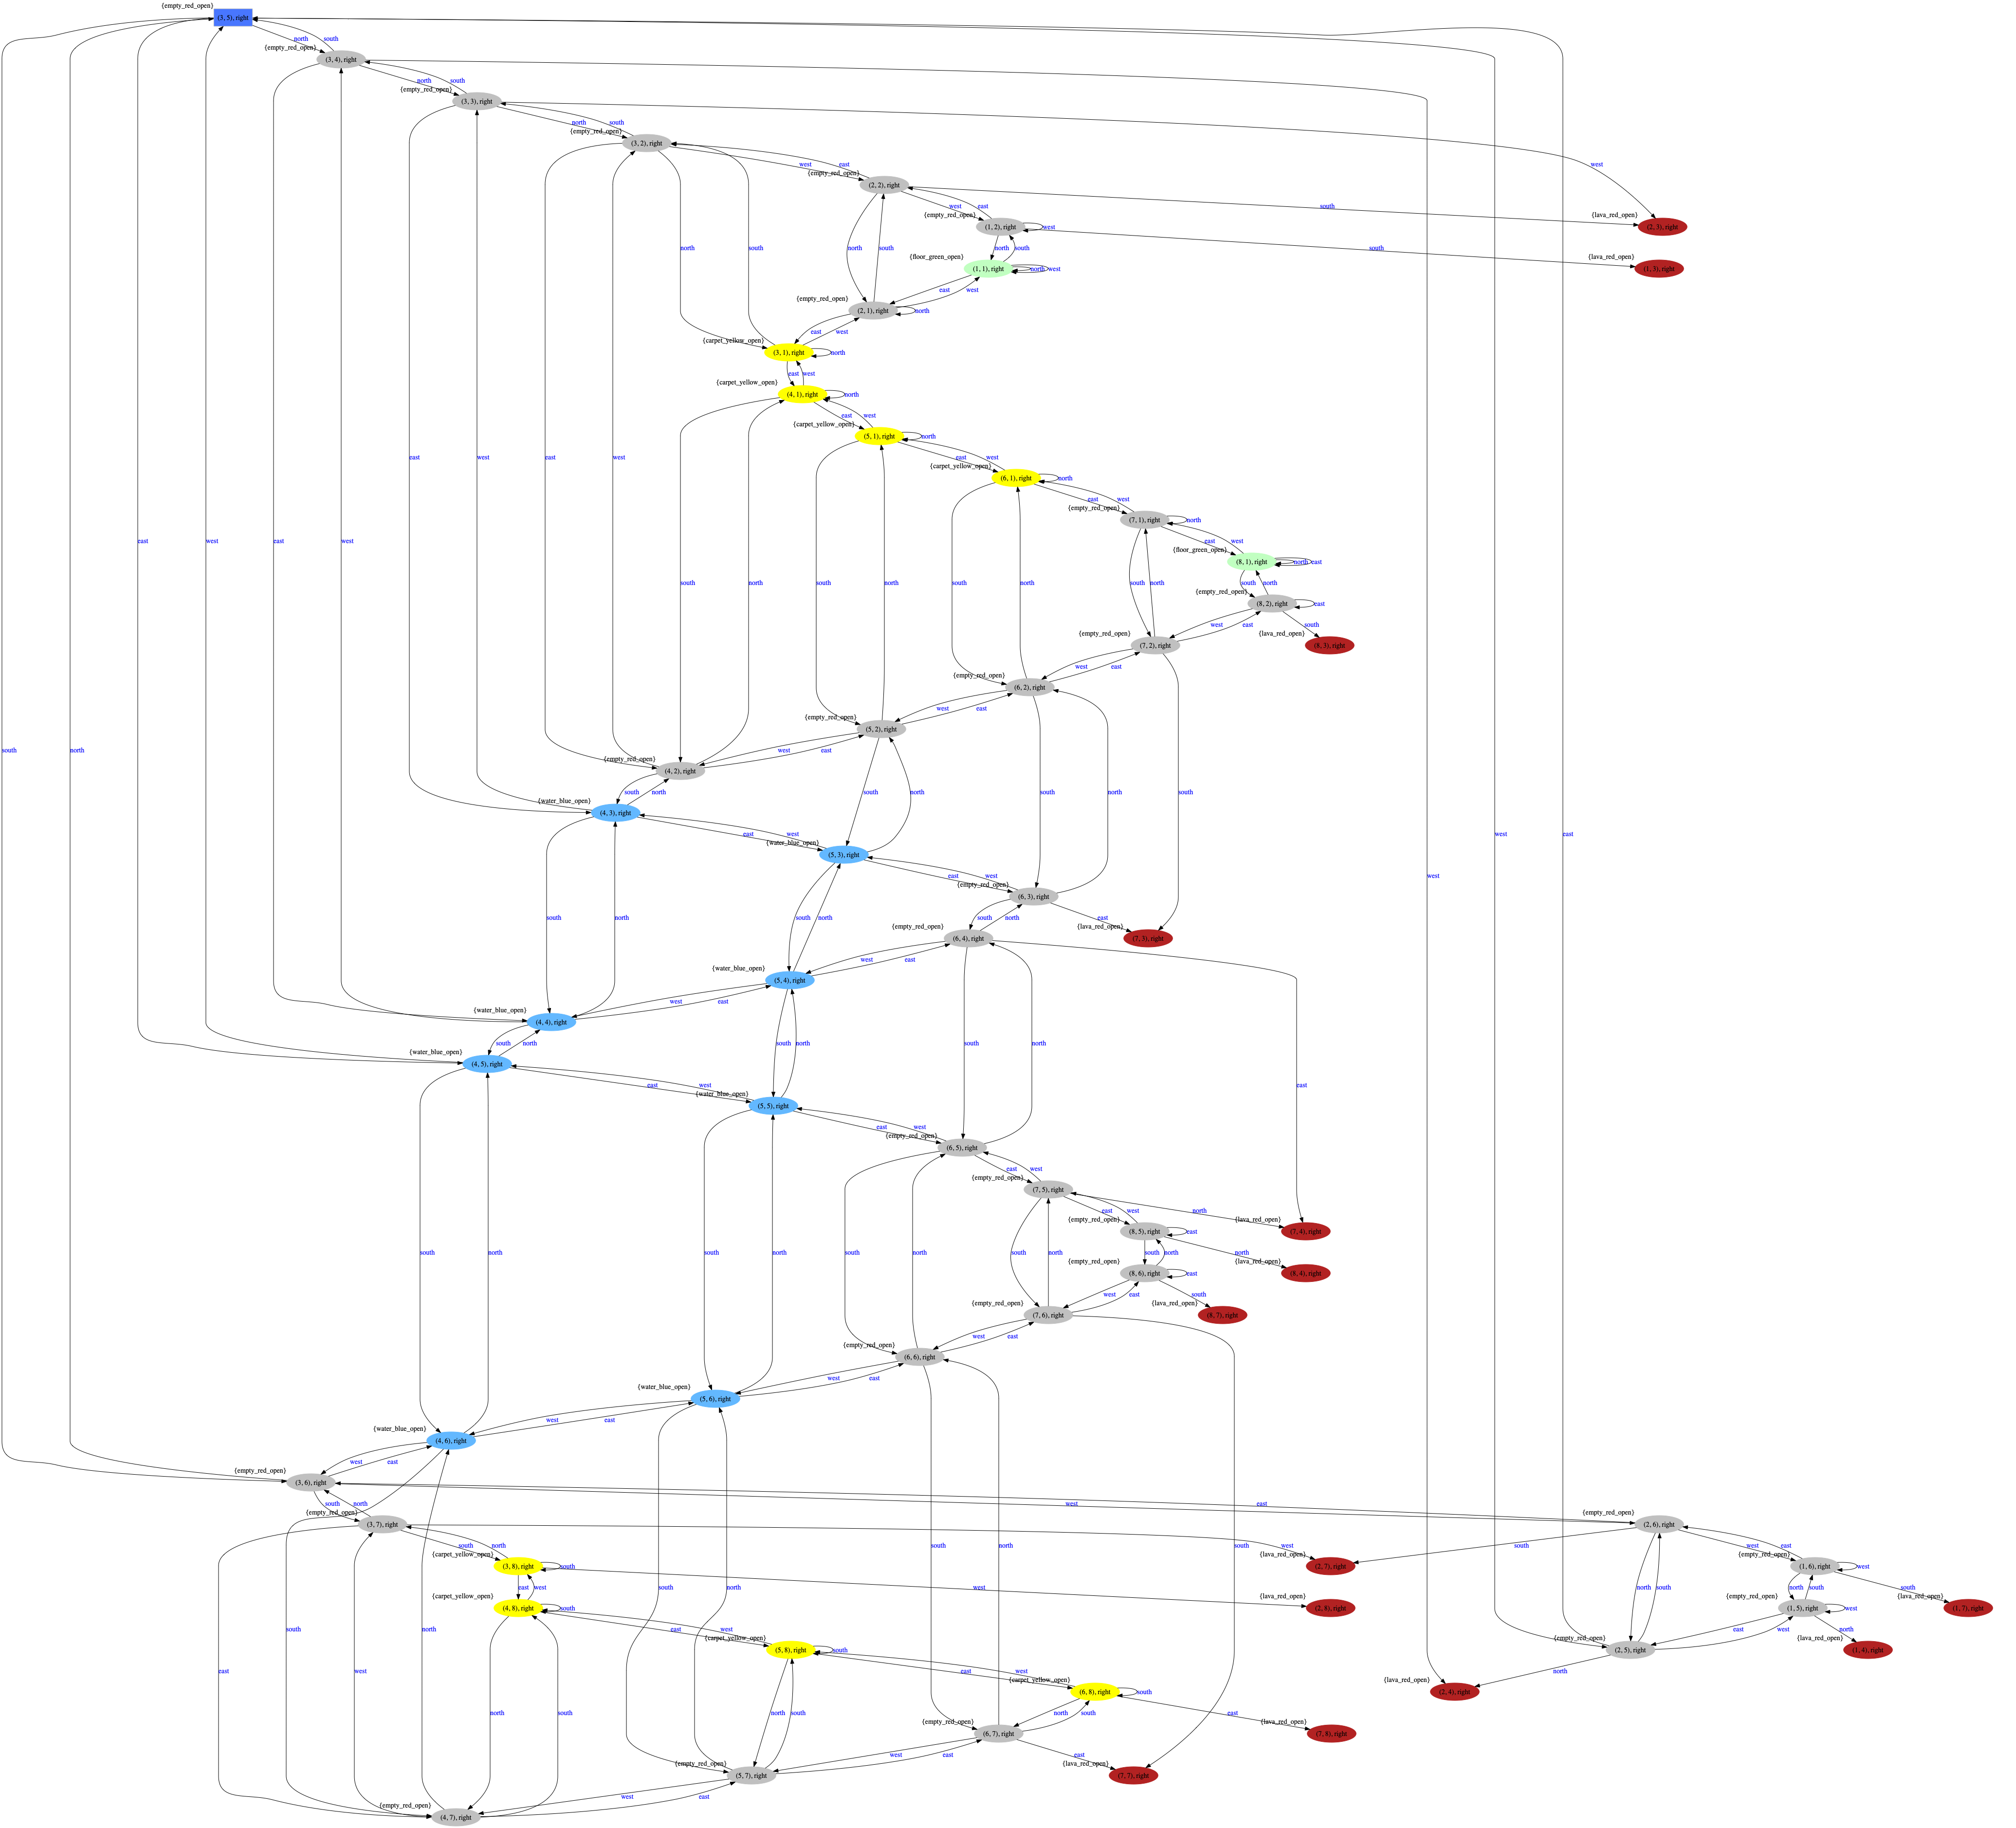

AttributeError: 'list' object has no attribute 'empty_transition_sym'

In [82]:
solve_environment(learned_pdfa, ENV_ID_1, show_figures=True)

In [ ]:
solve_environment(learned_pdfa, ENV_ID_2, show_figures=True)

In [ ]:
solve_environment(learned_pdfa, ENV_ID_1, actions_type='static')
solve_environment(learned_pdfa, ENV_ID_2, actions_type='static')
solve_environment(learned_pdfa, ENV_ID_1, actions_type='diag_static')
solve_environment(learned_pdfa, ENV_ID_2, actions_type='diag_static')

In [ ]:
all_actions_types = ['simple_static', 'static', 'diag_static']

all_experiments = itertools.product([ENV_ID_3, ENV_ID_4], all_actions_types)

for env_ID, actions_type in all_experiments:
    solve_environment(learned_pdfa, env_ID, actions_type=actions_type)

# Plots


x=num_samples, legend=['p', 'clf'], y=Average True Forward KL
x=num_samples, legend=['p', 'clf'], y=Average True Reverse KL
x=num_samples, legend=['p', 'clf'], y=Average False Forward KL
x=num_samples, legend=['p', 'clf'], y=Average False Reverse KL
x=num_samples, legend=['p', 'clf'], y=L1 Norm of Trace Probabilities
x=num_samples, legend=['p', 'clf'], y=L2 Norm of Trace Probabilities
x=num_samples, legend=['p', 'clf'], y=No of Nodes
x=num_samples, legend=['p', 'clf'], y=No of Edges
x=num_samples, legend=['p', 'clf'], y=Elapsed Time
x=num_samples, legend=['p', 'clf'], y=Safe


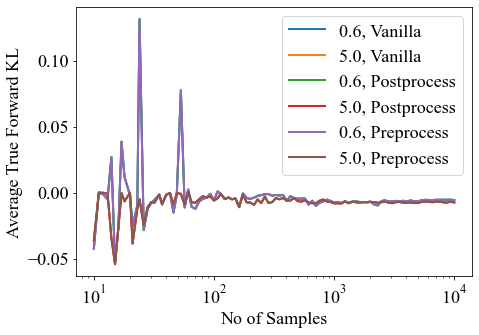

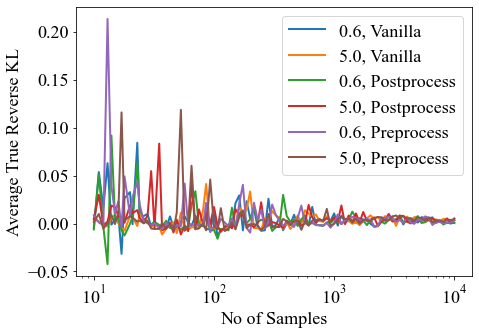

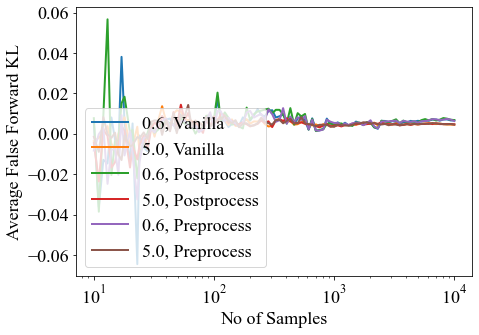

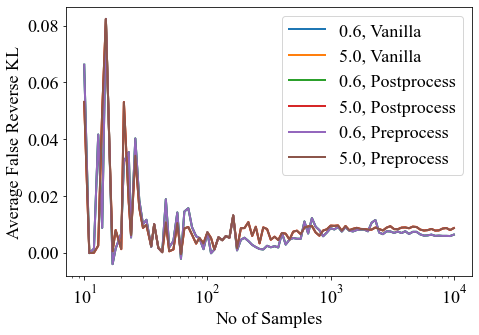

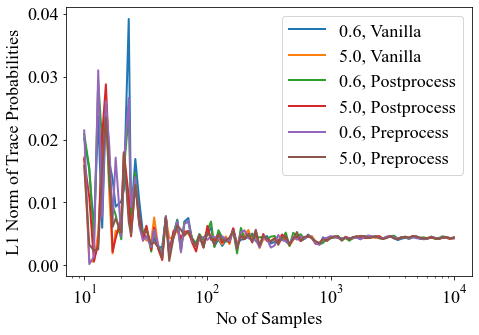

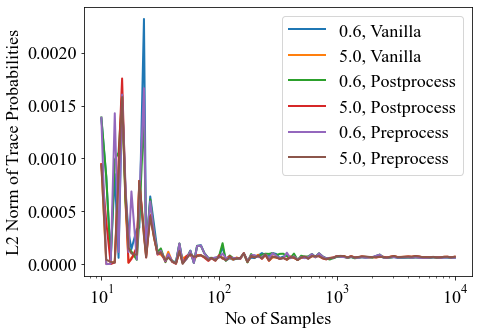

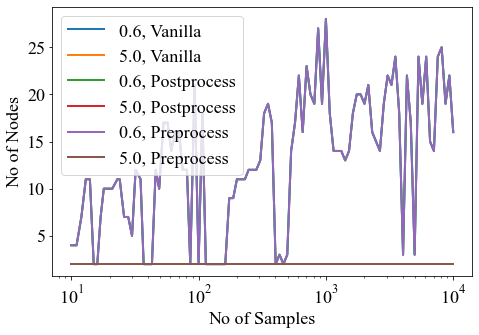

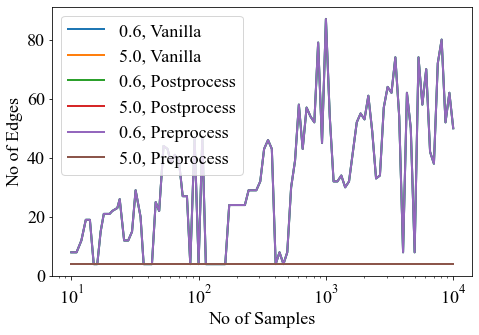

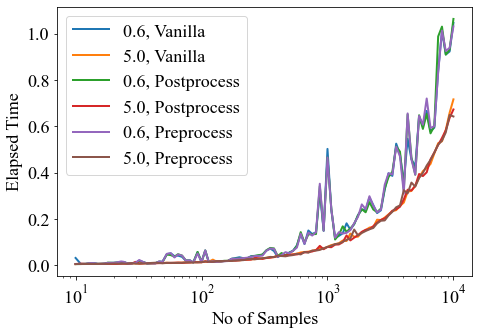

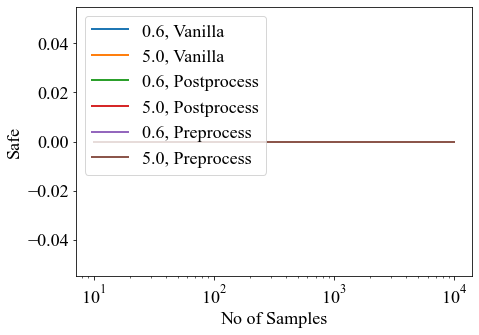

In [83]:
# Plot
evaluation.plot(x='num_samples', 
#                 selected_params={'p': '0.6', 'N': 20}, 
                selected_params={'N': 20}, 
                figsize=(7, 5), 
                logx=True,
#                 logy=True,
                lw=2,
#                 legend=False,
                style={'Preprocess': '-x', 'Postprocess': '-*'})
